In [ ]:
!pip install tensorflow lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 587.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00


In [ ]:
import numpy as np # библиотека нампи
import pandas as pd # библиотека пандас
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
import tensorflow as tf           # библиотека машинного обучения
from tqdm.notebook import tqdm   # отрисовка прохождения цикла
import gc                        # очиска памяти
import time                      # библиотека времени

# Графики с библиотекой mplfinance
Расширение библиотеки  matplotlib для работы и построения графиков из датасетов

In [ ]:
!pip install --upgrade mplfinance -q
import mplfinance as mpf  # библиотека для отрисовки OHCL
clear_output()

# **Данные с yfinance**

[документация](https://pypi.org/project/yfinance/)

In [ ]:
#!pip install yfinance -q
#!conda install -c ranaroussi yfinance --y
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf # requires yfinance - pip install yfinance
clear_output()

## 500 известных компаний с Wikipedia


Внимание - выбор случайного тикера может быть закомментирован

In [ ]:
# публичный список 500 известных компаний с Wikipedia
df_wiki = pd.read_html("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

# случайный индекс
idx = np.random.choice(df_wiki.index)
# тикер и компания по случайному индексу
#tiker  = df_wiki.loc[idx].Symbol
tiker  = 'WY'
#company = df_wiki.loc[idx].Security
company = 'Weyerhaeuser'
print(f'Берем данные по случайному тикеру {tiker} комании - {company}')

Берем данные по случайному тикеру WY комании - Weyerhaeuser


In [ ]:
# определяем параметры датасета
interval = "1d"
start = '2010-01-01'
stock = tiker
end = '2022-12-24'

# загружаем по тикеру и параметрам
df_tiker = yf.download(stock, start=start, end=end,  interval=interval, actions=False)
print(df_tiker.shape)
df_tiker.head()


[*********************100%***********************]  1 of 1 completed

(3268, 5)


Price,Close,High,Low,Open,Volume
Ticker,WY,WY,WY,WY,WY
Date,,,,,
2010-01-04,9.646343,9.679021,9.463350,9.561382,1832400
2010-01-05,9.851120,9.855477,9.517811,9.648521,1724500
2010-01-06,9.742196,9.853299,9.574452,9.655056,2254400
2010-01-07,9.698627,9.724768,9.533061,9.702984,1420700
2010-01-08,9.609307,9.683376,9.519989,9.639806,1310000


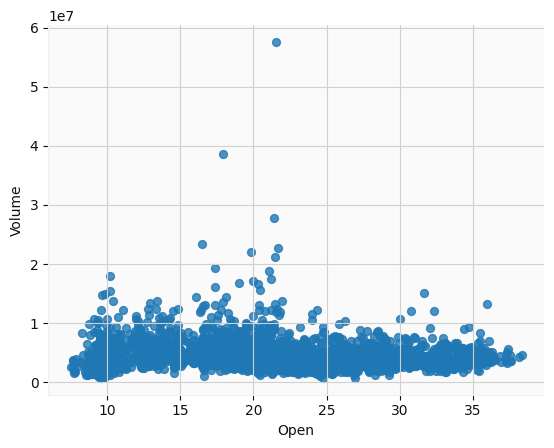

In [ ]:
# @title Open vs Volume

from matplotlib import pyplot as plt
df_tiker.plot(kind='scatter', x='Open', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

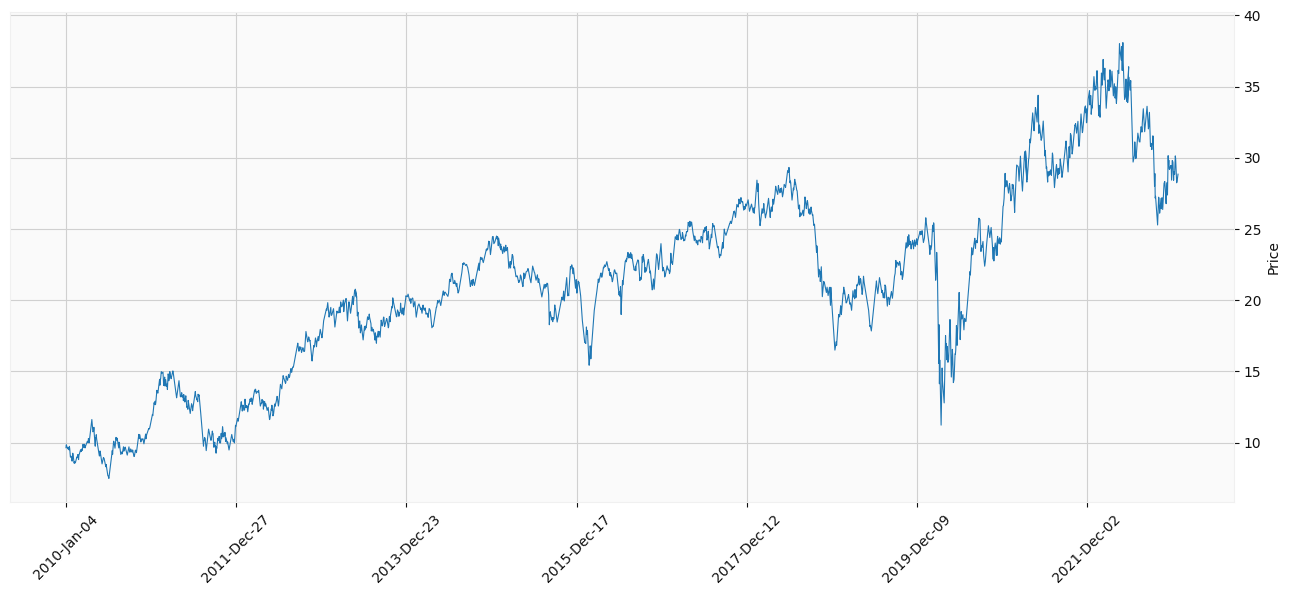

In [ ]:
# отрисовываем график с mplfinance
df_tiker.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
mpf.plot(df_tiker, style='yahoo', type='line', figsize=(17, 7))

# Подготовка данных

## Функции для подготовки данных


In [ ]:
def add_sma(df: pd.DataFrame, windows:list, indicators: list):
    """
    data - типа OHCL
    windows - набор окон
    Returns a pd.Series sma.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_SMA_{window}'] = copy[col].rolling(window = window).mean()
    return copy

def add_changes(df: pd.DataFrame, depth: int, indicators: list,
                only_indicators = False, type_change = 'diff'):
    """
    df - DataFrame df типа OHCL
    depth - глубина сбора производных
    indicators - индикаторы для получения данных
    only_indicators - выводить все колонки или только от индикаторов
    type_change - выбор между методами .diff() и .pct_change()
    Returns a DataFrame with the vwap.
    """
    methods = ('diff','pct_change')
    assert type_change in methods, f'В type_change доступо {methods}'
    copy = df.copy() if not only_indicators else df[indicators].copy()
    # Расчет индикаторов относительной доходности
    for i in range(1, depth + 1):
        indicators_changes = [f'{ind}_diff_{i}' for ind in indicators]
        # Относительная доходность в сотых долях за период i шагов назад
        for indicator_change, indicator in zip(indicators_changes, indicators):
          if type_change == 'diff':
            copy[indicator_change] = copy[indicator].diff(periods=i)
          elif type_change == 'pct_change':
            copy[indicator_change] = copy[indicator].pct_change(periods=i)
    return copy

def add_ema(df: pd.DataFrame, windows:list, indicators: list):
    """
    data - типа df.Close
    windows - набор окон
    indicators - индикаторы для получения данных
    Returns a pd.Series ema.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_EMA_{window}'] = copy[col].ewm(span=window).mean()

    return copy

def add_macd(df: pd.DataFrame, indicators: list):
    """
    data - типа DataFrame
    indicators - индикаторы для получения данных
    Returns a pd.Series with the MACD.
    """
    copy = df.copy()
    for col in indicators:
      exp1 = copy[col].ewm(span=12, adjust=False).mean()
      exp2 = copy[col].ewm(span=26, adjust=False).mean()
      copy[f'{col}_MACD'] = exp1 - exp2
    return copy


def add_vwap(df: pd.DataFrame, indicators: list):
    """
    df - DataFrame df типа OHCL
    indicators - индикаторы для получения данных
    Returns a DataFrame with the vwap.
    """
    q = df['Volume'].values
    copy = df.copy()
    for col in indicators:
      p = copy[col].values
      copy[f'{col}_VWAP'] = copy.assign(vwap=(p * q).cumsum() / q.cumsum()).vwap
    return copy

def add_obv(df: pd.DataFrame, indicators: list):
    """
    Добавит OBV осцилятор
    df - DataFrame df типа OHCL
    indicators - индикаторы для получения данных
    Returns a DataFrame with the _OBV.
    """
    copy = df.copy()
    for col in indicators:
    # https://stackoverflow.com/a/66827219
      copy[f'{col}_OBV'] = (np.sign(copy[col].diff()) * copy["Volume"]).fillna(0).cumsum()
    return copy

def data_indicators(df:pd.DataFrame, depth: int, windows:list,
                    use_columns:list):
    """
    Функция добавляющая данные индикаторов
    Returns a pd.Series
    """
    copy = df.copy()
    # набираем мз чего дополняем данные
    copy = add_vwap(copy, indicators = use_columns)
    copy = add_obv(copy, indicators = use_columns)
    copy = add_changes(copy, depth, use_columns, type_change = 'pct_change')
    copy = add_sma(copy, windows,indicators = use_columns)
    copy = add_ema(copy, windows,indicators = use_columns)
    copy = add_macd(copy, indicators = use_columns)
    # оставляем use_columns и их производные
    features = list(filter(lambda x: x.split('_')[0] in use_columns, copy.columns))
    return copy[features]

def num_to_class(df:pd.DataFrame, feature:list, column_prefix: str):
    '''
    добавляет колонки ONEHOT полученне из числоого 1D списка/массива feature
    column_prefix - префикс к колонкам ONEHOT
    '''
    copy = df.copy()
    copy[column_prefix] = feature
    copy = pd.get_dummies(copy,
                          columns = [column_prefix],
                          drop_first = True,
                          )
    return copy

def add_from_datetime(df:pd.DataFrame, add_classdays = False):
    """
    Функция добавляет:
    - миксовое числовое представление даты из datetime
    - представление ряда параметров времени как onehot
    Returns a pd.Series
    """
    copy = df.copy()
    # делаем еще колонки на основе даты
    day  =  copy.index.day                   # день месяца
    week_day =  copy.index.dayofweek+1         # день недели
    week  = copy.index.isocalendar()['week']   # недели года
    month = copy.index.month                   # месяц
    year  =  copy.index.year                   # год
    dayofyear =copy.index.dayofyear            # день года
    mix_day = day*week_day*month*year*dayofyear*week
    copy['Mix_day'] = np.log(mix_day).to_numpy()
    if add_classdays:
        copy = num_to_class(copy, week_day, 'cls_dw')
        copy = num_to_class(copy, month, 'cls_my')
    return copy

def clean_dataset(df:pd.DataFrame):
    """
    data - типа OHCL
    функция очистки
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    # индексы без nan, inf и -inf
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)



In [ ]:
# обогощаем датасет на основе функци индикаторов
FEATURES =  ['High', 'Low', 'Close'] #, 'Adj Close''Open',

# то что выбросили , но требуется для отображения с MPF
ADD4MPF = list(set(['High', 'Low', 'Close', 'Open']).difference(set(FEATURES)))
print('То что выбросили, но требуется для отображения с MPF - ', ADD4MPF)
print()

DIFFBACK = 25
SET_WIND = [3, 5, 7]
df_data = data_indicators(df_tiker, DIFFBACK, SET_WIND, FEATURES)
df_data = add_from_datetime(df_data, add_classdays = False)

# переводим Volume в Log_Volume в df_data
df_data['Log_Volume'] = np.log(df_tiker['Volume'])
df_data

То что выбросили, но требуется для отображения с MPF -  ['Open']



,Close,High,Low,High_VWAP,Low_VWAP,Close_VWAP,High_OBV,Low_OBV,Close_OBV,High_diff_1,...,Low_EMA_5,Close_EMA_5,High_EMA_7,Low_EMA_7,Close_EMA_7,High_MACD,Low_MACD,Close_MACD,Mix_day,Log_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,9.646343,9.679021,9.463350,9.679021,9.463350,9.646343,0.0,0.0,0.0,NaN,...,9.463350,9.646343,9.679021,9.463350,9.646343,0.000000,0.000000,0.000000,10.378479,14.421137
2010-01-05,9.851120,9.855477,9.517811,9.764573,9.489755,9.745626,1724500.0,1724500.0,1724500.0,0.018231,...,9.496027,9.769209,9.779853,9.494471,9.763359,0.014076,0.004344,0.016335,11.517913,14.360448
2010-01-06,9.742196,9.853299,9.574452,9.798992,9.522612,9.744295,-529900.0,3978900.0,-529900.0,-0.000221,...,9.533176,9.756414,9.811613,9.529057,9.754207,0.024771,0.012217,0.020259,12.288021,14.628394
2010-01-07,9.698627,9.724768,9.533061,9.784411,9.524664,9.735324,-1950600.0,2558200.0,-1950600.0,-0.013044,...,9.533128,9.732410,9.779853,9.530522,9.733881,0.022614,0.014944,0.019626,12.884005,14.166660
2010-01-08,9.609307,9.683376,9.519989,9.768917,9.523947,9.715998,-3260600.0,1248200.0,-3260600.0,-0.004256,...,9.528084,9.685152,9.748229,9.527069,9.693047,0.017364,0.015867,0.011781,13.374211,14.085538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,28.242413,28.956947,28.013395,20.886301,20.380095,20.635431,463223400.0,764098800.0,758534800.0,0.000316,...,28.560460,28.877116,29.469908,28.658027,28.984622,0.134286,0.112765,0.091643,22.839482,14.928913
2022-12-20,28.315695,28.489748,27.848499,20.887754,20.381522,20.636899,460449300.0,761324700.0,761308900.0,-0.016134,...,28.323140,28.689976,29.224868,28.455645,28.817390,0.041420,0.033740,0.023857,23.586751,14.835837
2022-12-21,28.498909,28.801212,28.169124,20.889212,20.382957,20.638347,463124500.0,763999900.0,763984100.0,0.010932,...,28.271801,28.626287,29.118954,28.384015,28.737770,-0.006964,-0.002981,-0.014908,24.043827,14.799535


from matplotlib import pyplot as plt
df_data['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data['High_VWAP'].plot(kind='hist', bins=20, title='High_VWAP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='Close', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='Low', y='High_VWAP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data.plot(kind='scatter', x='High_VWAP', y='Low_VWAP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_data['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_data['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_data['High_VWAP'].plot(kind='line', figsize=(8, 4), title='High_VWAP')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# параметр, который будем предсказывать
WIND_PRED = 3
USE2PRED = 'Close'
TYPE_PRED = 'SMA'
PRED_PRICE = f'{USE2PRED}_{TYPE_PRED}_{WIND_PRED}'
print(f'Предсказывать будем цену - {PRED_PRICE}')

# добавляем колонку TYPE_PRED WIND_PRED
df_data = add_sma(df_data, [WIND_PRED], [USE2PRED])
print(df_data.shape)

# Очистка датасетта от строк с nan, inf и -inf
df_data = clean_dataset(df_data)
print(df_data.shape)

Предсказывать будем цену - Close_SMA_3
(3268, 107)
(3243, 107)


In [ ]:
def df_for_mpf(df: pd.DataFrame, raw_df: pd.DataFrame, columns:list):
  '''
  Добавление колонок Open, High, Low, Close из raw_df
  необходимых для отображения в mpf.plot()
  если удалили для тренировачного набора
  '''
  copy = df.copy()
  for col in columns:
    copy = copy.join(raw_df[col])
  return copy

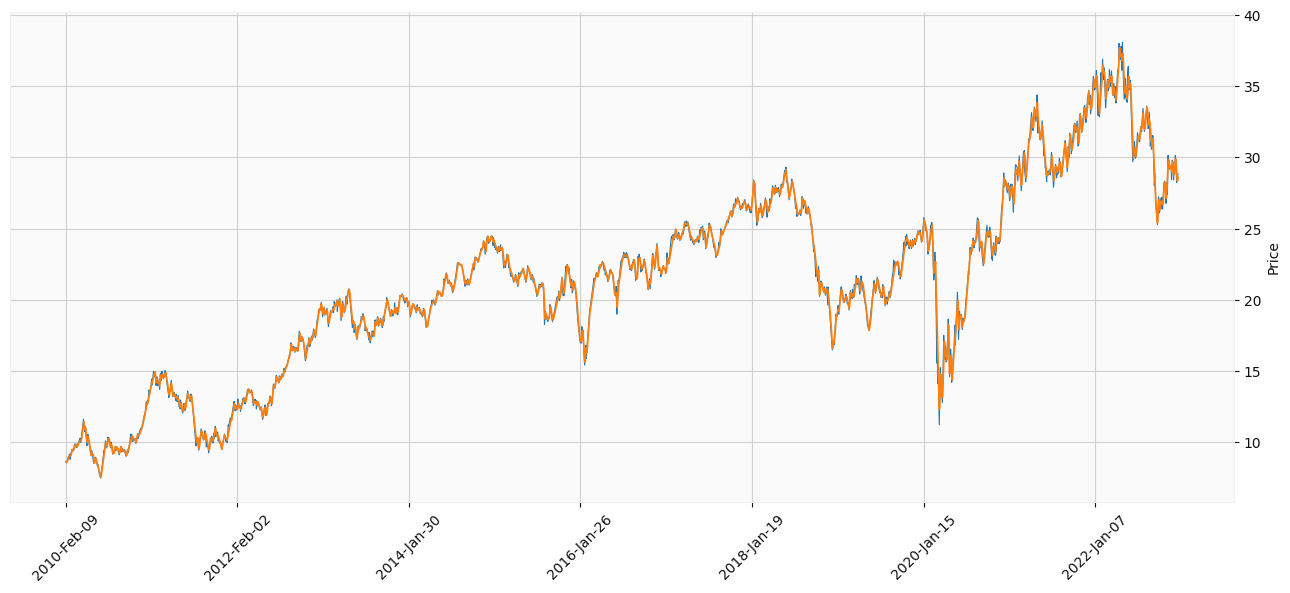

In [ ]:
# отрисовываем график Close с добавленным графиком по колонке df_data[PRED_PRICE]
df2show = df_for_mpf(df_data, df_tiker, ADD4MPF) # датафрейм, если убрали колонку требуемуе, то нужно добавить
mpf.plot(df2show,
         addplot= (mpf.make_addplot(df_data[PRED_PRICE])), # добавленый график df_data[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));

## Делим на Tain и Test


Учебный датасет


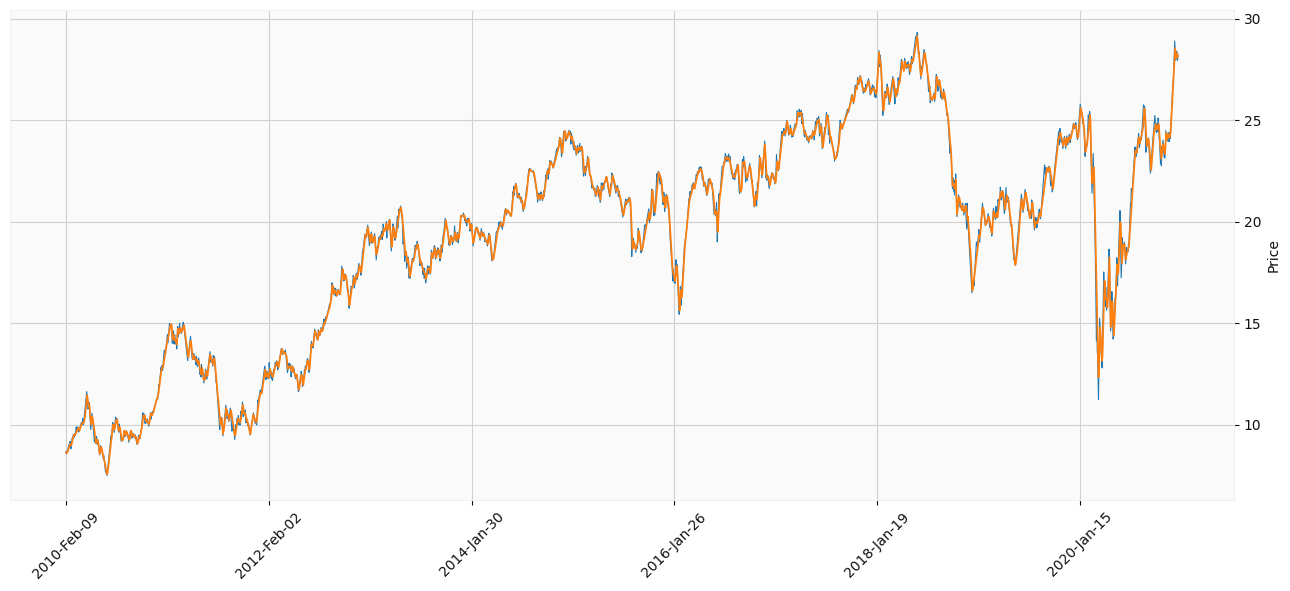

Тестовый датасет


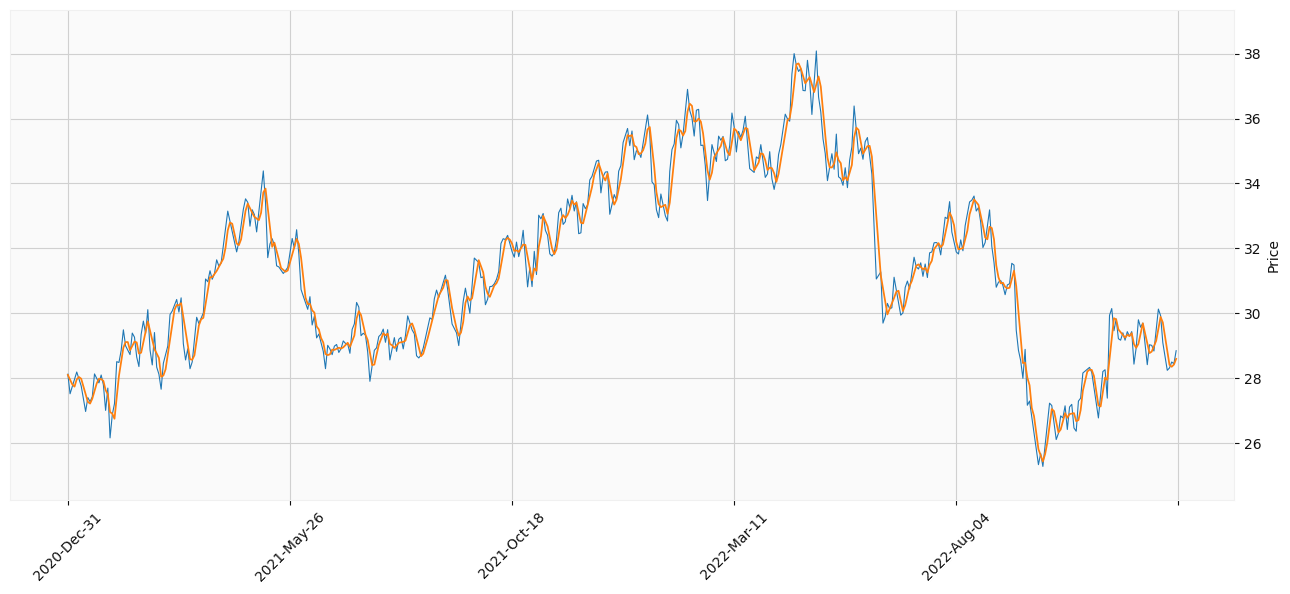

In [ ]:
test_size = 500 # для теста откусим последние test_size значений
# Тренировочная выборка
print(f'Учебный датасет')
df_train = df_data[:-test_size]

df2show = df_for_mpf(df_train, df_tiker[:-test_size], ADD4MPF)
# отрисовываем график Close с добавленным графиком по колонке df_train[PRED_PRICE]
mpf.plot(df2show, # датафрейм
         addplot= (mpf.make_addplot(df_train[PRED_PRICE])), # добавленый график df_train[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
df_test = df_data[-test_size:]

df2show = df_for_mpf(df_test, df_tiker[-test_size:], ADD4MPF)
# отрисовываем график Close с добавленным графиком по колонке df_test[PRED_PRICE]
mpf.plot(df2show,  # датафрейм
         addplot= (mpf.make_addplot(df_test[PRED_PRICE])), # добавленый график df_test[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


## Подготовка данных для обучения

### Деление на Train датасет на TRAIN и VAL части

Предсказывать будем на 10_ть шагов

In [ ]:
# Формируем параметры загрузки данных
DEPTH = DIFFBACK                         # Анализируем по DIFFBACK прошедшим точкам
VAL_LEN = 500                            # Используем 300 записей для проверки
PREDICT_LAG = 5                          # на сколько шагов вперед
TRAIN_LEN = df_train.shape[0] - VAL_LEN  # Размер тренировочной выборки
TRAIN_COLUMNS = df_train.columns[:-1]    # колонки для тренировочной выборки

# Делим данные на тренировочную и тестовую выборки
x_train, x_val = df_train[TRAIN_COLUMNS][:TRAIN_LEN - PREDICT_LAG + 1], \
                 df_train[TRAIN_COLUMNS][TRAIN_LEN + DEPTH + 2:-PREDICT_LAG + 1]

x_train.shape, x_val.shape

((2239, 106), (469, 106))

In [ ]:
# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
X_SCAILER.fit(x_train)                  # обучаем X_SCAILER
x_train = X_SCAILER.transform(x_train)  # трансформируем x_train
x_val = X_SCAILER.transform(x_val)      # трансформируем x_val

x_train[0], x_val[0]

(array([0.05441129, 0.05098591, 0.0516552 , 0.01132658, 0.00915561,
        0.00900277, 0.10698253, 0.01042622, 0.0552446 , 0.29805095,
        0.58884982, 0.58339439, 0.35187573, 0.60831394, 0.4943524 ,
        0.24281914, 0.43760633, 0.43682936, 0.21621994, 0.3051086 ,
        0.31086877, 0.25344161, 0.37551159, 0.27190217, 0.40109766,
        0.46998906, 0.41858701, 0.33297878, 0.46292826, 0.44850879,
        0.33067212, 0.45960787, 0.42748094, 0.3329975 , 0.41881002,
        0.38603354, 0.33973212, 0.38059301, 0.37289014, 0.34955428,
        0.3974194 , 0.39325608, 0.34285871, 0.39768687, 0.39087224,
        0.27285589, 0.35227078, 0.37383895, 0.24626116, 0.26605486,
        0.27820806, 0.23556015, 0.26392841, 0.24626157, 0.26422049,
        0.25766088, 0.30629509, 0.26762287, 0.27121779, 0.27492385,
        0.26567976, 0.2845995 , 0.26234496, 0.27401548, 0.29564213,
        0.29480828, 0.28158773, 0.2796412 , 0.29802073, 0.28683587,
        0.28668676, 0.28956667, 0.27520129, 0.27

In [ ]:
# Функция разделения набора данных на выборки для обучения нейросети
# x_data - набор входных данных
# predict_lag - количество шагов в будущее для предсказания
def future_sequence(x_data, predict_lag):
    # Определение максимального индекса
    y_len = x_data.shape[0] - (predict_lag - 1)
    # отстоящих на predict_lag шагов вперед
    y = [x_data[i:i+ predict_lag] for i in range(y_len)]
    # Возврат результатов в виде массивов numpy
    return np.array(y)

In [ ]:
# Для подготовки yTrain на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
# Для таргета берем колонку PRED_PRICE
y_train = future_sequence(df_train[PRED_PRICE][:TRAIN_LEN], PREDICT_LAG)
y_val =  future_sequence(df_train[PRED_PRICE][TRAIN_LEN + DEPTH + 2:], PREDICT_LAG)

# делаем ли np.log для у
MAKE_LOG = True
if MAKE_LOG:
  y_train = np.log(y_train)  # заменяем  y_train на log(y_train)
  y_val = np.log(y_val)      # заменяем  y_val на log(y_val)

print(y_train.shape, y_val.shape)
y_train[0], y_val[0]

(2239, 5) (469, 5)


(array([2.15346588, 2.15177644, 2.15489938, 2.15279028, 2.16312428]),
 array([2.99058871, 2.99320471, 2.999066  , 3.00166003, 3.00811599]))

In [ ]:
from pickle import dump, load
import joblib

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Y_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
Y_SCAILER.fit(y_train)                    # обучаем Y_SCAILER
y_train = Y_SCAILER.transform(y_train)    # трансформируем y_train
y_val = Y_SCAILER.transform(y_val)        # трансформируем y_val

joblib.dump(Y_SCAILER, 'scaler.save')
y_train[0], y_val[0]

(array([0.09639276, 0.09514024, 0.09745555, 0.09589189, 0.10355339]),
 array([0.71702538, 0.71896485, 0.72331034, 0.72523352, 0.73001989]))

### Формируем генератор данных TimeseriesGenerator
- https://ru-keras.com/sequence-preprocessing/
- https://keras.io/api/preprocessing/timeseries/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

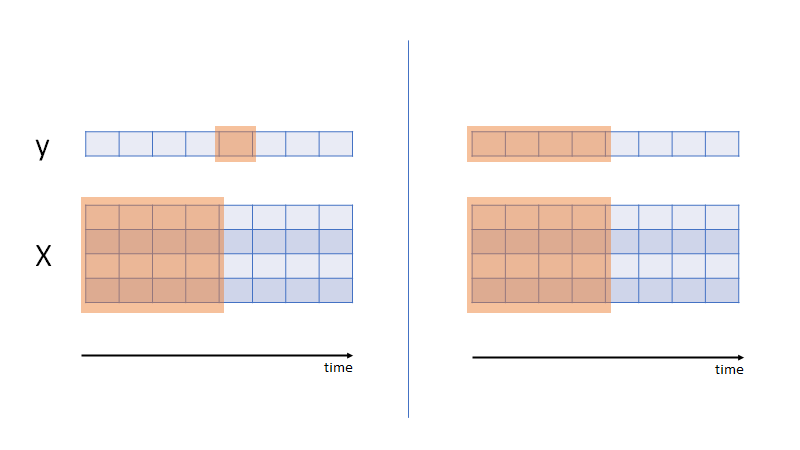

In [ ]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator

In [ ]:
BATCH_SIZE = 32
# Создаем генератор для обучения
train_datagen = TSG(x_train, y_train,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val, y_val,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]

(32, 25, 106) (32, 5)


In [ ]:
print(x_val.shape)
print(y_val.shape)

(469, 106)
(469, 5)


In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val, y_val,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = 64)   # Размер batch будет равен 64

In [ ]:
# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in range(len(DataGen)):
  x_batch, y_batch = DataGen[i]
  XVAL.append(x_batch)
  YVAL.append(y_batch)

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.concatenate(XVAL, axis=0)
YVAL = np.concatenate(YVAL, axis=0)

print(XVAL.shape,YVAL.shape)

(444, 25, 106) (444, 5)


# Классы для генерации случайной нейронной сети

In [ ]:
import random as random # Импортируем модель randim
import inspect # для получения имен аргументов функции

## Класс для определения слоев

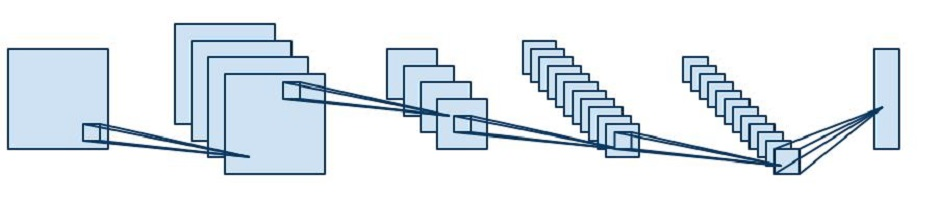

In [ ]:
class Set_net():
    '''
    Класс для формирования списка списков блоков,
    имен слоев и значений парамметров слоев
    type_net       - тип сети:
                     0 - Dense
                     1 - Conv
                     2 - Recur
                     None - любая
    activ_lays     - список функций активаций
    activ_out      - выходная функция активации
    neiro_out      -  количество нейронов/сверток выходного слоя
    limit          -  ограничения роста сети
                      по умолчание 10**3
    '''
    def __init__(self,
                 type_net,      # тип сети
                 activ_lays,    # список функций активаций
                 activ_out,     # выходная функция активации
                 neiro_out,     # количество нейронов/сверток выходного слоя
                 limit = 10**3, # ограничения роста сети
                 ) -> None:

        # списки имен используемых слоев
        self.main_lays =  ['Dense', 'Conv1D']
        self.recur_lays = ['Recur', 'EmbRecur']
        self.add_lays =   ['SCnv1D', 'Conv1DT',
                           'Conv1D_dilation_block',
                           'Inceptionv_1D']
        self.optim_lays = ['Dropout','BatchN', 'LayNorm']
        self.pooling_lays = ['MaxP1D','AvgP1D', 'Ups1D']
        self.embed_lays =   ['Embed']
        self.activ_lays = activ_lays
        self.activ_out = activ_out
        self.neiro_out = neiro_out

        # все используемые именя слоев
        self.use_layers  = self.main_lays + self.recur_lays + self.optim_lays\
                           + self.pooling_lays + self.embed_lays\
                           + self.add_lays + ['activ',]

        # создаем self переменные
        self.type_net = type_net
        self.limit = limit
        self.layer = tf.keras.layers

        # создаем список функций слоев
        self.makers_layer = (self.make_dense,
                             self.make_conv1D,
                             self.make_recur,
                             self.make_embrecur,
                             self.make_dropout,
                             self.make_batchn,
                             self.make_laynorm,
                             self.make_maxp1D,
                             self.make_avg1D,
                             self.make_upsam1D,
                             self.make_embedding,
                             self.make_sepconv1D,
                             self.make_conv1DT,
                             self.make_convblock_dilation,
                             self.make_inceptionv_1D,
                             self.make_activ,
        )
        # создаем словарь соответсвия имен и функций слоев
        self.dict_layers = dict(zip(self.use_layers, self.makers_layer))
        pass


    # Функции создания слоев
    def make_dropout(self, x, rate):
        lay = self.layer.Dropout(rate)(x)
        return lay

    def make_batchn(self, x):
        lay = self.layer.BatchNormalization()(x)
        return lay

    def make_laynorm(self, x):
        lay = self.layer.LayerNormalization()(x)
        return lay

    def make_dense(self,x, neiron):
        lay = self.layer.Dense(neiron)(x)
        return lay

    def make_conv1D(self, x, filter, kernel, pads):
        # корректируем размерность под conv1D
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 0)
            x = tf.keras.layers.Reshape(newshape)(x)

        lay = self.layer.Conv1D(filters = filter,
                                kernel_size = kernel,
                                padding = pads)(x)
        return lay

    def make_sepconv1D(self, x, filter, kernel, pads):
        # корректируем размерность под Separableconv1DT
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 0)
            x = tf.keras.layers.Reshape(newshape)(x)

        lay = self.layer.SeparableConvolution1D(filters = filter,
                                                kernel_size = kernel,
                                                  padding = pads)(x)
        return lay

    def make_conv1DT(self, x, filter,  kernel, pads):
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 0)
            x = tf.keras.layers.Reshape(newshape)(x)

        lay = self.layer.Conv1DTranspose(filters = filter,
                                          kernel_size = kernel,
                                          padding = pads)(x)
        return lay


    def make_maxp1D(self, x, pool):
        lay = self.layer.MaxPooling1D(pool_size = pool)(x)
        return lay

    def make_avg1D(self, x, pool):
        lay = self.layer.AveragePooling1D(pool_size = pool)(x)
        return lay

    def make_upsam1D(self, x, upsize):
        lay = self.layer.UpSampling1D(size = upsize)(x)
        return lay

    def get_recurlay(self, type_recur):
        '''
        определение типа рекурентной сети по параметру
        '''
        if type_recur == 'lstm':
           layer = self.layer.LSTM
        elif type_recur == 'gru':
          layer = self.layer.GRU
        return layer

    def make_recur(self, x, type_recur, recuron, sequences):
        layer = self.get_recurlay(type_recur)
        # корректируем размерность под рекурентный слой
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 0)
            x = tf.keras.layers.Reshape(newshape)(x)

        lay = layer(units = recuron, return_sequences = sequences)(x)
        return lay

    def make_embedding(self, x, in_emb, out_emb):
        # корректируем размерность под эмбединг
        if len(x.shape) > 2: x = self.layer.Flatten()(x)
        lay = self.layer.Embedding(input_dim = in_emb,
                                             output_dim = out_emb)(x)
        return lay

    def make_embrecur(self, x, recuron, type_recur):
        layer = self.get_recurlay(type_recur)
        # корректируем размерность под рекурентный слой
        if len(x.shape) > 2:  x = self.layer.Flatten()(x)
        # парамметры для Embedding слоя
        emb_in = x.shape[1]
        emb_out = min(64, emb_in//3)
        lay = self.layer.Embedding(input_dim = emb_in,
                                              output_dim = emb_out)(x)
        lay = layer(recuron,return_sequences=True)(lay)
        lay = layer(recuron,return_sequences=False)(lay)
        return lay

    def make_convblock_dilation(self, x, filter, kernel):
        def convs(x, f, k, rate, ln = False):
            x = self.layer.Conv1D(filters = f,
                                  kernel_size = k,
                                  padding = "causal",
                                  dilation_rate = rate,
                                  activation="sigmoid")(x)
            x = self.layer.LayerNormalization()(x) if ln else x
            return x
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 1)
            x = tf.keras.layers.Reshape(newshape)(x)

        a = convs(x = x, f = filter,  k = kernel, rate = 2, ln = True)
        b = convs(x = x, f = filter,  k = kernel, rate = 4, ln = True)
        c = convs(x = x, f = filter,  k = kernel, rate = 8, ln = True)
        d = convs(x = x, f = filter,  k = kernel, rate = 16,ln = True)
        lay = self.layer.concatenate([x, a, b, c, d], axis = -1)
        return lay

    def make_inceptionv_1D(self, x, set_filters, kernel_sets, pad_sets):
        '''
        Блок Inseption - как пример сложных блоков для отбора
        Опробирован один тип блока - Inception A
        пример отсюда - https://github.com/Sakib1263/
        Inception-InceptionResNet-SEInception-SEInceptionResNet-1D-2D-Tensorflow-Keras/
        blob/main/Codes/Inception_1DCNN.py
        '''
        def Conv_1D_Block(x, filters, kernel, strides=1, padding="same"):

            # 1D Convolutional Block with BatchNormalization
            x = self.layer.Conv1D(filters,
                                       kernel,
                                       strides=strides,
                                       padding=padding,
                                       kernel_initializer="he_normal")(x)
            x = self.layer.BatchNormalization()(x)
            x = self.layer.Activation('relu')(x)
            return x

        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            # высчитываеи корректировку размерности тензора под lstm
            newshape = self.__redim__(x.shape[1], 2, sort = 0)
            x = tf.keras.layers.Reshape(newshape)(x)

        # Inception Block
        branch1x1 = Conv_1D_Block(x, set_filters[5],
                                     kernel_sets[5],
                                     padding= pad_sets[5])

        branch3x3_ = Conv_1D_Block(x, set_filters[4],
                                     kernel_sets[4],
                                     padding=pad_sets[4])
        branch3x3 = Conv_1D_Block(branch3x3_, set_filters[3],
                                             kernel_sets[3],
                                             padding=pad_sets[3])

        branch5x5_ = Conv_1D_Block(x, set_filters[2],
                                     kernel_sets[2],
                                     padding=pad_sets[2])
        branch5x5 = Conv_1D_Block(branch5x5_, set_filters[1],
                                             kernel_sets[1],
                                             padding=pad_sets[1])

        branch_pool_ = self.layer.MaxPooling1D(pool_size=3, strides=1,
                                                   padding='same')(x)
        branch_pool = Conv_1D_Block(branch_pool_, set_filters[0],
                                                 kernel_sets[0],
                                                 padding=pad_sets[0])

        lay = self.layer.concatenate([branch1x1, branch3x3,
                                           branch5x5, branch_pool],
                                           axis=-1)
        return lay

    def make_activ(self, x, activ):
        lay = self.layer.Activation(activ)(x)
        return lay


    # Метод построение случайного бота блока на основе bot_list блока
    def __buildbot__(self, bot_list):
        '''
        Метод создает случайным образом в заданном диапазоне
        значения пришедщим парраметрам слоев в списке bot_list
        собирает их в список и выдает этот список

        Инсептион только один тип. Вероятно нужно тут выбор типа,
        а сами сочетания под типы уже в блоке

        '''
        # Для Inception A
        insep_flts_sets = [(64, 96, 128, 16, 32, 32),    # Inception Block 1
                           (128, 128, 192, 32, 96, 64),  # Inception Block 2
                           (192, 96, 208, 16, 48, 64),   # Inception Block 3
                           (160, 112, 224, 24, 64, 64),  # Inception Block 4
                           (128, 128, 256, 24, 64, 64),  # Inception Block 5
                           (112, 144, 288, 32, 64, 64),  # Inception Block 6
                           (256, 160, 320, 32, 128, 128),# Inception Block 7
                           (384, 192, 384, 48, 128, 128) # Inception Block 8

        ]

        insep_krnl_sets = [(1, 1, 3, 1, 3, 1),    # Inception A
                           #(1, 1, 3, 1, 3, 3),   # Inception B
                           #(1, 1, 5, 1, 3, 3),   # Inception C
                           #(1, 1, 7, 1, 7, 7),   # Inception D
        ]

        insep_pads_sets = [('valid','valid','same','valid','same','same'),   # Inception A
                           #('same','same','same','same','same','same'),     # Inception B
                           #('same','same','same','same','same','same'),   # Inception C
                           #(1, 1, 7, 1, 7, 7),   # Inception D
        ]
        bot = []
        for el in bot_list:
            if el == 'neiron':
                bot.append(2**random.randint(2,7))
            if el == 'activ':
                bot.append(random.randint(0, len(self.activ_lays)-1))
            if el == 'filter':
                bot.append(2**random.randint(2,7))
            if el == 'kernel':
                bot.append(random.randint(2,5))
            if el == 'pads':
                bot.append(random.choice(('valid','same')))
            if el == 'stride':
                bot.append(random.randint(1,2))
            if el == 'pool':
                bot.append(random.randint(2,4))
            if el == 'upsize':
                bot.append(random.randint(2,4))
            if el == 'rate':
                bot.append(round(random.random()*0.5,2))
            if el == 'type_recur':
                bot.append(random.choice(('lstm','gru')))
            if el == 'recuron':
                bot.append(random.randint(2,30))
            if el == 'sequences':
                bot.append(random.choice(('False','True')))
            if el == 'in_emb':
                bot.append(random.randint(10,200))
            if el == 'out_emb':
                bot.append(max(20, bot[-1]//3))
            if el == 'set_filters':
                bot.append(random.choice(insep_flts_sets))
            if el == 'kernel_sets':
                bot.append(random.choice(insep_krnl_sets))
            if el == 'pad_sets':
                bot.append(random.choice(insep_pads_sets))
        return bot

    def __redim__(self, size, dim, sort = None):
        '''
        Метод метод считает выходной список размерностей
        длины dim из прешедшего размера парамметров size,
        на основе разложения на простые множители
        input:
        size - входящий размер размерности слоя
        dim  - длина всписка выходной размерности
        sort - сортировать ли список простых множителей
                как - 0 - возраст-й, 1 - убывающий
        output:
        outshape - выходной список размерностей
                   длины dim
        '''
        # собираем в res простые множители чиcла n
        res, n, d = [], size, 2
        while d * d <= n:
            if n % d == 0:
                res.append(d)
                n //= d
            else:
                d += 1
        if n > 1:
            res.append(n)
        ##########################################

        # сортируем или перемешиваем список простых множителей
        if sort == 0 or sort == 1:
            res = sorted(res, reverse=sort)
        else:
            res = np.random.permutation(res)
        ##########################################

        # формируем список размерностей длины dim
        s = len(res)//dim  # целое число отношения len(res) и dim
        if s >= 1 and dim == 2:
            # получим outshape размерности 2 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:])]

        elif s >= 1 and dim == 3:
            # получим outshape размерности 3 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:2*s]),
                         np.prod(res[2*s:])]

        elif s < 1 and dim == 3:
            s = len(res)//(dim-1)
            # получим outshape размерности 2 из произведений частей и
            # добавляем ось справа
            outshape = [int(np.prod(res[:s])), int(np.prod(res[s:])), 1]

        elif (s < 1 and dim == 2) or dim == 1:
            # просто добавляем ось справа
            outshape = [size, 1]
        return outshape

## Класс генерация блоков

In [ ]:
class Make_blocks():
    '''
    Класс отвечающий за генерацию
    блоков сети на основе данных из
    ранее инициализированного класса set_net

    set_net - класс парамметров сети
    '''

    def __init__(self,
                set_net: object,
                ):
        # переназначенм переменные из класса set_net
        self.set_net = set_net
        self.neiro_out = set_net.neiro_out
        self.main_lays = set_net.main_lays
        self.add_lays = set_net.add_lays
        self.recur_lays = set_net.recur_lays
        self.activ_out = set_net.activ_out
        self.limit = set_net.limit
        self.type_net = set_net.type_net

        # определяем слои сети на основы заданного типа сети
        #############################################
        # если тип не задан
        if self.type_net == None:
            self.net_lays = self.main_lays + self.add_lays + self.recur_lays
        # если рекурентный тип сети
        elif self.type_net == 2:
            self.net_lays = self.recur_lays
        # если 0 - Dense или 1 - Conv тип сети
        else:
            # выбираем из main_lays индексом, который равен типу сети
            self.net_lays = [self.main_lays[self.type_net]]
        #############################################
        # отобранные по типу слою и плюс слои оптимизации
        self.__used_lays__ = self.net_lays + self.set_net.optim_lays

        pass

    # ФУНКЦИИ КОРРЕКЦИИ СПИСКОВ БЛОКОВ
    def __correct__(self, block_list: list, name: str,
                   level = 0, insert = False):
        '''
        Метод коррекции пришедщего списка списка
        block_list - пришедщий список
        level - порог выше котого коррекция
        name - имя добавляемого слоя
        insert - если True то вставит до последнего,
              иначе вставит за последним
        '''
        # подбрасываем монетку
        bias = random.random()
        if bias >= level: # если выше порога, то корректируем для вывода
            if insert: # вставляем
               block_list.insert(-1, name)
            else: # добавляем
               block_list.append(name)
        return block_list

    # ФУНКЦИИ ГЕНЕРАЦИИ СПИСКОВ БЛОКОВ
    def __generateblock__(self,
                        max_lays: int,        # мак.количество слоев в блоке
                        prob_mp = 0.27,       # появление пуллинг слоя
                        prob_el = 0.25,       # Embedding до LSTM
                        prob_ac = 0.23        # появление слоя активации
                        ):
        '''
        Внутренний метод для геннерации списка
        из имен слоев
        max_lays - мак. возможное количество слоев в блоке
        '''
        # определяем количество слоев в блоке не более max_lays
        layers = random.randint(0, max_lays)
        block_list = [] # список для сбора имен слоев
        # итерируемся по слоям
        for i in range(layers):
            if not i: # если 0_й слой
              # вставляем случайное имя из слоев сети
              block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
            else:
              # если пришло имя из слоя оптимизации
              if block_list[-1] in self.set_net.optim_lays:
                # вставляем случайное имя из слоев сети
                block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
              else: # иначе выбираем из слоев сети и оптимизации
                block_list = self.__correct__(block_list,
                                          random.choice(self.__used_lays__))
              # случайное появление пулинга после cвертки
              if block_list[-1]=="Conv1D" and i < layers:
                # случайно по prob_mp добавляем пуллинг слой
                block_list = self.__correct__(block_list,
                                      random.choice(self.set_net.pooling_lays),
                                      level = prob_mp)
              # случайное появление Embeding переd рекуррентным слоем
              if block_list[-1]=="Recur" and i < layers:
                # случайно по prob_el вставляем Embeding слой
                block_list = self.__correct__(block_list,
                                            self.set_net.embed_lays[0],
                                            level = prob_el,
                                            insert = True)
              # случайное появление активации
              backactiv_1 = (block_list[-1] != 'activ' and i < layers)
              backactiv_2 = (block_list[-2] != 'activ' and 1 < i < layers)
              if backactiv_1 or backactiv_2:
                # случайно по prob_ac добавляем 'activ'
                block_list = self.__correct__(block_list, 'activ',
                                            level = prob_ac)
              # если набрали длину
              if len(block_list) == layers:
                  break

        return block_list


    def sostav_blockov(self, q_lst: list):
        '''
        Метод генерирует список из списков блоков
        размера полученнного из q_lst
        q_lst - список длины количества блоков,
                где значения списка определяет
                количество слоев в блоке
        '''
        blockov_list = []
        for i in range(len(q_lst)):
            block = self.__generateblock__(max_lays = q_lst[i])
            blockov_list.append(block)
        return  blockov_list


    def buildblock_bot(self, block_lst: list):
        '''
        Метод собирает список списков парамметров
        слоев каждого блока будущей сети
        block_lst - список списков слоев будущей сети
        '''
        botov_lst = []
        for i in range(len(block_lst)):
            # получаем список имен парамметров слоев блока
            bot_lst = self.__bot_block__(block_lst[i])
            # получаем список самих парамметров слоев блока из имен парамметров
            bot = self.set_net.__buildbot__(bot_lst)
            botov_lst.append(bot)
        return   botov_lst

    ######################################################################

    # ФУНКЦИИ БОТОВ
    # определение состава бота для блока из созданого случайно block_list
    def __bot_block__(self, block_list: list):
        '''
        Метод формирует список списков парамметров слоев в блоках
        на основе списка имен слоев блока из block_list
        block_list - список имен слоев блока
        '''
        bot_list = []
        for lay in block_list:
          if lay == 'activ':
              # если имя слоя 'activ', то просто добавляем 'activ'
              bot_list.append('activ')
          else: # иначе
              # созданный в set_net словарь соответсвия
              # имен слоев и функций их формирующих
              maker_lay = self.set_net.dict_layers[lay]
              # методом param_layer определяем парамметры
              # у функций формирующих слои
              param = self.__param_layer__(maker_lay)
              # добавляем эти парамметры в bot_list
              if len(param): bot_list += param
              else: pass
        return bot_list


    # Построение случайного бота попупуляции
    def buildpopulbot(self, q_tyblocks: int, q_lays: int):
        '''
        Метод случйно генерирует список, который будет
        ботом_попупаляции сетей
        q_tyblocks - максимально возможное количество блоков в сети
        q_lays - максимально возможное количество слоев в блоках в сети
        '''
        # генерируем количество блоков
        qblocks = random.randint(1, q_tyblocks)
        # генерируем количество слоев в блоке
        genlays = random.randint(1, q_lays)

        # собираем бота популяции
        populbot = []
        # добавляем:
        # ген 0 макс. возможное количество блоков сети популяции
        populbot.append(qblocks)
        # ген 1 макс. возможное количество слоев в блоках сети популяции
        populbot.append(genlays)
        # ген 2 типа данной сети
        populbot.append(self.type_net)
        # ген 3 делать или нет пред_выходном слой
        populbot.append(random.randint(0,1))
        # ген 4 ко-ва нейронов/фильтров пред_выходном слое
        populbot.append(2**random.randint(2,7))
        # ген 5 окон если свертки в пред_выходном слое
        populbot.append(random.randint(2,5))
        # ген 6 делать/нет слой нормализации перед посл-й активацией
        populbot.append(random.randint(0,1))
        # ген 7 какую делаем активацию в выходном слое из списка активаций
        populbot.append(random.randint(0, len(self.set_net.activ_out)-1))
        # ген 8 под сложность сети, будет назначается методом сборки сети
        populbot.append(0)
        # ген 9 под ярусность сети, будет назначается методом сборки сети
        populbot.append(0)
        return populbot


    # ФУНКЦИИ ФОРМИРОВАНИЯ БЛОКОВ
    # без степеней - прямые значения нейронов
    def __buildblock__(self, tensor: object,
                       block_list: list, bot: list):
        '''
        Метод строет блок слоев на основе списка
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''

        # будет добавляться больше или меньше 0 значение
        # если к-во параметров > или < 1
        b=0
        # иттерируеимя по слоям блока
        for i, lay in enumerate(block_list):
          # созданный в set_net словарь соответсвия
          # имен слоев и функций их формирующих
          maker_lay = self.set_net.dict_layers[lay]
          # получаем колчество парамметров функции слоя
          k = len(self.__param_layer__(maker_lay))
          # формируем список аргументов для функции слоя
          if k: # если есть доп.параметры в слое
            # получаем доп.параметры в слоя
            parametrs = [bot[i+b+j] for j in range(k)]
            # собираем аргументы для активации
            if lay=='activ':
              args = [tensor]+[self.set_net.activ_lays[parametrs[0]]]
            # собираем аргументы для других многопарамметных слоев
            else: args = [tensor]+parametrs
          # собираем аргументы если слой без параммeтров
          else: args=[tensor]
          # формируем слой на основе нужных и собранных args
          tensor = maker_lay(*args)
          # обнавляем b
          b+=k-1
        return tensor # выводим выходной тензор блока


    def __buildblockout__(self,
                      indata: object,    # входные данные
                      bot_pop: list,     # бот популяции (может)
                       ):
        '''
        Метод строет блок слоев на основе списка
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        indata     - входящий тензор
        bot_pop    - бот популяции
        output:
        x     - исходящий тензор блока
        '''
        x = indata

        if bot_pop[2] == 0:
            # Добавление предпоследнего полносвязного слоя
            if bot_pop[3]!=0:
                x = self.set_net.make_dense(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        elif bot_pop[2] == 1:
            # Добавление предпоследнего conv1D слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под conv1D
                newshape = self.set_net.__redim__(x.shape[1], 2, sort = 1)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_conv1D(x, bot_pop[4], bot_pop[5],
                                             pads = 'same')
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        elif bot_pop[2] == 2:
            # Добавление предпоследнего LSTM слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под lstm
                newshape = self.set_net.__redim__(x.shape[1], 2, sort = 1)
                x = tf.keras.layers.Reshape(newshape)(x)
                # выбрал 2 парамметра рекурентного выходного слоя жестко
                x = self.set_net.make_recur(x, 'lstm', bot_pop[4], False)
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        else: #pass
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)
        return x

    ###########################################################
    ######         вспомогательные методы класса         ######
    ###########################################################
    def __param_layer__(self, method: object):
        '''
        Метод выводит количеству управляющих
        парамметров пришедшей функции method
        на онове inspect.getfullargspec
        method - функция у которой определяютя
                 количество управляющих парамметров
        '''
        return inspect.getfullargspec(method).args[2:]


    # простое соединение произвольного к-ва блоков
    def __flatconcat__(self, set_blocks: list):
        '''
        Метод конкантенации списка тензоров блоков
        через промежуточный перевод в вектор Flatten
        с контролем пространства паремметров и при
        превышении к-ва размерностей или размера
        паремметров, применение GlobalAveragePooling1D
        взамен Flatten
        '''
        out = []

        # иттерируемся по списку тензоров
        for i in range(len(set_blocks)):
            # не является ли уже вектором
            if set_blocks[i].shape != (None, 1):
                # Берем shape тензора
                control_shape = set_blocks[i].shape
                # Если много размерностей или много парамметров у тензора
                if np.prod(control_shape[1:]) > self.limit:
                    if len(control_shape) == 2:
                       #print('control_shape', control_shape)
                       # высчитываеи корректировку размерности тензора под conv1D
                       newshape = self.set_net.__redim__(control_shape[1], 2, sort = 0)
                       #print('newshape', newshape)
                       lay  = tf.keras.layers.Reshape(newshape)(set_blocks[i])
                    elif len(control_shape) > 2:
                       # сортируем размерности по возрастанию, кроме 0
                       newshape = sorted(control_shape[1:], reverse=1)
                       # перемножаем кроме последнего и берем последний
                       newshape = (np.prod(newshape[:-1]), newshape[-1])
                       #print('newshape', newshape)
                       lay  = tf.keras.layers.Reshape(newshape)(set_blocks[i])
                       # Добавляем слой GlobalAveragePooling1D
                       lay = tf.keras.layers.GlobalAveragePooling1D(keepdims=False)(lay)
                    out.append(lay)
                else:
                    if len(control_shape) > 2:
                      # Добавляем слой Flatten
                      lay = tf.keras.layers.Flatten()(set_blocks[i])
                    else:
                      lay = set_blocks[i]
                    #print(f'shape of lay_{i} = {lay.shape}')
                    out.append(lay)
            else: # Иначе выходим
                break
        if len(out) > 1:
          # Конкантенируем тензоры по axis = -1 и выводим
          try: out = tf.keras.layers.concatenate(out, axis = -1)
          # Если попался слой с shape !=2
          except:
            out_ = []
            for lay in out:
              if lay.shape !=2:
                lay = tf.keras.layers.Flatten()(lay)
              out_.append(lay)
            out = tf.keras.layers.concatenate(out_, axis = -1)
        else: out = out[0]
        return  out


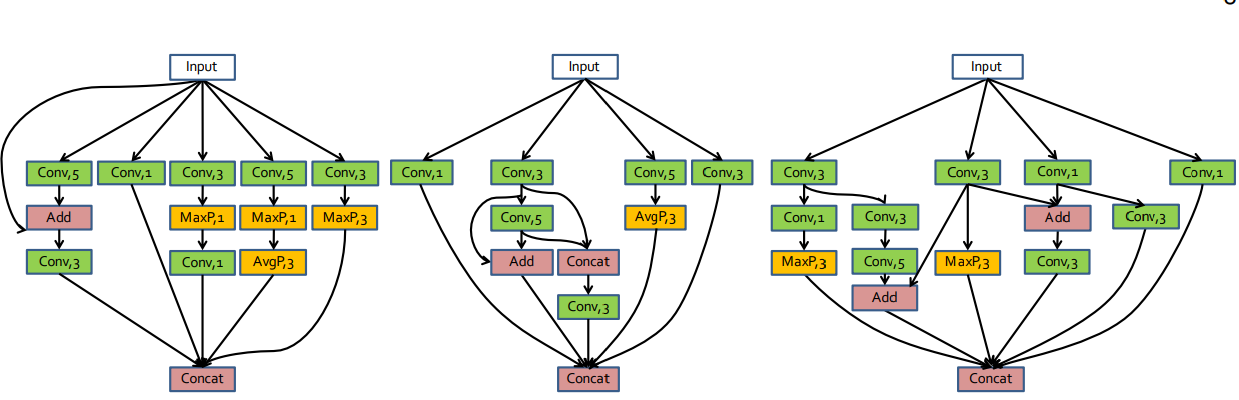

## Класс сборки нейронки

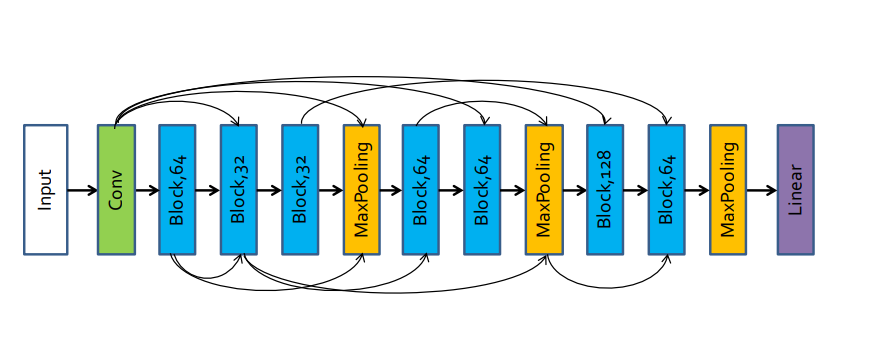

In [ ]:
!pip install stopit -q # установка библиотека контроля времени
from stopit import threading_timeoutable as timeoutable

In [ ]:
MESSAGE_1 = 'Превышение лимита на сборку модели'
TIMELIMIT_1 = 8 # лимит времени в секундах на сборку модели

MESSAGE_2 = 'Превышение лимита на тестовое обучение модели'
TIMELIMIT_2 = 25 # лимит времени на тестовое обучение модели
MAX_HIDDEN = 10*5 # лимит на допустимый объем скрыттых слоев см. ниже

In [ ]:
class WildregressModel():
      '''
      Класс который формирует и выдает сеть

      input_shape - размерность входящих в сеть данных
      control_level_shape - размер допустимого размера парамметров
                            слоев когда требуется применение
                            GlobalAveragePooling1D для понижения
                            размерности
      q_level - количество блоков с которого можно строить
                многоярусную сеть
      '''

      def __init__(self,
                  input_shape: list,
                  control_level_shape = MAX_HIDDEN,
                  q_level = 3
                  ):

          self.input_shape = input_shape
          self.control = control_level_shape
          self.q_level = q_level
          pass

      # Декоратор для контроля времени
      @timeoutable(default = MESSAGE_1)
      def __call__(self,
                  bot_pop: list,
                  bot: list,
                  setblockov: list,
                  blocks: object
                  ):
          '''
          Класс который формирует и выдает сеть на основе
          bot_pop - бот_популяции сетей
          bot - спискок парамметров слоев блоков
          setblockov - списка списков слоев имен блока
          blocks - класс построения блоков
          '''
          # Входной слой
          inputs =  tf.keras.layers.Input(self.input_shape)
          # размерность даннх сети без 0го, которы None
          dim_net = len(self.input_shape) - 1

          ##### отбор блоков с основными слоями для входа нейронки ############
          idx=[] # хранения индексов блоков с основными слями сети
          # отбираем индексы блоков с основными слями сети
          for block in setblockov:
              if [x for x in blocks.net_lays if x in block]:
                idx.append(setblockov.index(block))
          # берем первый по счету, и если был посев, для входа уходит сразу
          in_nb = idx[0]
          # получаем тензор от первого блока
          in_block = blocks.__buildblock__(inputs, setblockov[in_nb],
                                           bot[in_nb])

          #####################################################################
          ############# отбор для скрытых блоков ##############################
          # ищем и оставляем только один пустой блок
          new_setblockov = []
          new_bot = []
          emp = 0 # счетчик пустых блоков

          # Если был посев, то первый блок для входа уходит сразу -
          for i in range(1,len(setblockov)): # не попадет во внутр.блоки
              #print('metka 4')
              if emp == 0 and setblockov[i] == []:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])
                  emp+= 1
              elif emp != 0 and setblockov[i] == []:
                  pass
          # оставляем только один пустой блок
          # на его основе создается проброс от входной части до concat
              else:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])

          #####################################################################
          #  print('Сборка многоярусной модели')
          #####################################################################
          if len(new_setblockov) > self.q_level:
              ############### БЛОК соединения скрытых блоков  #################
              ########## создание гена для ярусности и  сложности сети ########
              if not bot_pop[9]:
                  # определяем ярусность сети
                  bot_pop[8] = random.choice(np.arange(2,
                                                       len(new_setblockov)-1))
                   # отбор блоков в ярусы
                  bot_pop[9] = [0] + [len(new_setblockov)] \
                                   + sorted(np.random.choice(np.arange(1,
                                            len(new_setblockov)-1),
                                            bot_pop[8], replace=False))
                  tiers = bot_pop[9]  # состав ярусов
              else:
                  tiers = bot_pop[9]  # состав ярусов
            ###################################################################
              brickblock = [] # ссписок для сборв внутренних блоков
              # итеррируемся по ярусам
              for j in range(len(tiers)-1):
                  indata = in_block if not j else concdata
                  hidblock = []
                  # отбираем в conc только возможные блоки
                  for i in range(tiers[j], tiers[j+1]):
                      ##########################################################
                      # создаем внутренний блок
                      hid = blocks.__buildblock__(indata,
                                              new_setblockov[i],
                                              new_bot[i])
                      # собираем список внутренних блоков для конкатенации
                      hidblock.append(hid)
                  # еслм набрали в список внутренних блоков
                  if len(hidblock)>1:
                    # конкатенируем через выпрямления в вектора
                    concdata = blocks.__flatconcat__(hidblock)
                    # ищем замену размерности
                    newshape = blocks.set_net.__redim__(concdata.shape[-1],
                                                dim_net+1,
                                                sort = 0)
                    # трансформируем размерность тензора
                    concdata = tf.keras.layers.Reshape(newshape)(concdata)
                    brickblock.append(concdata)
                  elif len(hidblock)==1: brickblock.append(hidblock[-1])
                  else: pass
              # соединяем блоки
              to_out = blocks.__flatconcat__(brickblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если есть блоки для одноэтажной модели
          elif len(new_setblockov):
          #####################################################################
          #    print('Сборка одноэтажной модели')
          #####################################################################
              hidblock = []
              for i in range(len(new_setblockov)):
                  hid =  blocks.__buildblock__(in_block, new_setblockov[i],
                                           new_bot[i])
                  hidblock.append(hid)
              ################################################################
              # соединяем блоки
              to_out = blocks.__flatconcat__(hidblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если нет блоков, то берем тензор с входного блока
          else:
              # переводим в вектор входной тензор
              in_block_out = blocks.__flatconcat__([in_block])
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(in_block_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Финальный слой под вашу задачу
          out = tf.keras.layers.Dense(units = blocks.neiro_out,
                                      activation = blocks.activ_out[bot_pop[7]]
                                      )(out_block)
          # формируем граф модели
          model = tf.keras.Model(inputs, out)
          return model



# Функции оценки

## функция для оценки и отрисовки автокорреляции

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
def get_scalepred(model: object, x: list, y: list, у_scaler: object):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (model) и проверочную выборку
  Выдаёт результаты предсказания y_pred
  И правильные ответы в исходной размерности y_true (какими они были до нормирования)
  model - нейронная сеть
  x - x данные для предикта
  y - y проверочные данные
  у_scaler - ранее обученный скэйлер для y

  '''
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  y_pred = у_scaler.inverse_transform(model.predict(x))
  y_true = у_scaler.inverse_transform(y)
  if MAKE_LOG:
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
  return (y_pred, y_true)


# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def show_predict(start: int, finish: int, pred_lags: int,
                 y_pred: list, y_true: list, name: str, figsize=(25,10)):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  finish - длина графика, которую отрисовываем
  pred_lags - какие шаги предсказания отрисовываем
  y_pred - предсказания модели
  y_true - верные ответы
  name - имя предсказания
  '''
  plt.figure(figsize=(figsize))
  for lag in pred_lags:
      plt.plot(y_pred[start:start+finish, lag],
              label=f'Прогноз на {lag+1}й шаг')
      plt.plot(y_true[start:start+finish, lag],
              label=f'Базовый ряд на {lag+1}м шаге')
  plt.xlabel('Отсчеты')
  plt.ylabel(f'Значение {name}')
  plt.legend()
  plt.show()


# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  '''
  # Функция расчёта корреляции дух одномерных векторов
  a, b - вектора
  '''
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


# Функция рисуем корреляцию прогнозированного сигнала с правильным
def auto_corr(pred_lags: list, corr_steps: list, y_pred: list, y_true: list,
             show_graf = True, return_data = False, figsize=(18,7)):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  pred_lags -  какие шаги предсказания для проверки корреляцию
  corr_steps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  show_graf - показываем график или нет
  return_data - возвращаем массивы автокорреляции или нет
  '''
  # Запоминаем размер проверочной выборки
  y_len = y_true.shape[0]
  # Если нужно показать график
  if show_graf:
    plt.figure(figsize=(figsize))
  # Проходим по всем каналам
  for lag in pred_lags:
    # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    corr = []
    # Создаём пустой лист, в нём будут самокорреляции графика с собой
    # при смещении на i шагов обратно
    own_corr = []
    # Смещаем сигнал по предсказаниям для проверки автокорреляции
    for i in range(corr_steps):
      #print('i', i)
      # Получаем сигнал, смещённый на i шагов назад
      # y_pred[i:, lag]
      # Сравниваем его с верными ответами, без смещения назад
      # y_true[:y_len-i, lag]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(y_true[:y_len-i, lag], y_pred[i:, lag]))
      # Рассчитываем корреляцию графика самого с сообой и добавляем в лист
      own_corr.append(correlate(y_true[:y_len-i, lag], y_true[i:, lag]))

    # Отображаем график коррелций для данного шага
    if show_graf: # Если нужно показать график
      plt.plot(corr, label= f'Предсказание на {str(lag+1)}й шаг')
      plt.plot(own_corr, label=f'Эталон на {str(lag+1)}м шаге')
  # Если нужно показать график
  if show_graf:
    plt.xlabel('Отсчеты')
    plt.ylabel('Значение корреляции')
    plt.legend()
    plt.show()
  # Если нужно вернуть массивы автокорреляции
  if return_data:
    return corr, own_corr

## функция для комплексной оценки сети

чистка памяти - https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session


In [ ]:
# Колбек для подсчета в функции ниже средней скорости на эпохе
class TimeHistory(tf.keras.callbacks.Callback):
    # создаем пустой список вначале обучения
    def on_train_begin(self, logs={}):
        self.times = []
    # запоминаем время вначале эпохи
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    # запоминаем время обучения на эпохе
    def on_epoch_end(self, batch, logs={}):
        # добавляем в список в конце эпохи
        self.times.append(time.time() - self.epoch_time_start)

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()



# Функция на оценки с добавленным колбеком времени
@timeoutable(default = MESSAGE_2) # Декоратор для контроля времени
def evaluate_model(model, y_scaler, train_gen,
                   val_gen, ep, verb, optimizer,
                   loss, channels, predict_lag):
      '''
      Функция оценки модели на точность и автокорреляцию, с обучение
      и проверкой эффекта автокорреляции
      model       - тестируемая модель
      y_scaler    - ранее обученный скэйлер для ответов
      train_gen   - генератор данных для обучения модели
      val_gen     - генератор данных для проверки модели
      ep          - количество эпох оценосного обучения
      verb        - показывать ли процесс обучения
      optimizer   - используемый оптимайзер для обучения
      loss        - используемая функция потерь для обучения
      channels    - каналы в ответе модели для проверки автокорреляции
      predict_lag - на сколько шагом предсказание
      '''
      # сбрасываем оценку на случай пересечения названия с global переменной
      val = 0
      # Компилируем модель
      model.compile(optimizer, loss)
      # инициализируем колбек в дальнейшем для поиска более быстрых и оптимизации поиска
      time_callback = TimeHistory()
      # очистка ОЗУ
      clear_ozu = GarbageCollectorCallback()
      # понижение шага
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      mode='min',
                                                      factor = 0.6,
                                                      patience = 1,
                                                      min_lr = 1e-9,
                                                      verbose = 1)
      # обучаем модель
      history = model.fit(train_gen,
                          epochs=ep,
                          verbose=verb,
                          validation_data=val_gen,
                          callbacks=[time_callback, clear_ozu, reduce_lr])
      # получаем данные по времени каждой эпохи
      times_back = time_callback.times
      # берем среднее время эпохи
      time_ep = np.mean(times_back)

      # Прогнозируем данные текущей сетью
      (pred_val, y_val_true) = get_scalepred(model, XVAL, YVAL, y_scaler)
      # Возвращаем автокорреляцию
      corr, own_corr = auto_corr(pred_lags = channels,
                                 corr_steps = predict_lag,
                                 y_pred = pred_val,
                                 y_true = y_val_true,
                                 show_graf = False,
                                 return_data = True)
      # Считаем MAE автокорреляции и умножаем (прибавляем) ошибку обучения
      val = 100*tf.keras.losses.MAE(corr, own_corr).numpy()*history.history["val_loss"][-1]

      # чистим память
      tf.keras.backend.clear_session()
      del model
      gc.collect()
      # Возвращаем точность и среднее время эпохи
      return val, time_ep

## Тест сборки сети

In [ ]:
# параметры для создания сети
q_tyblocks = 7  # возможное количество блоков
q_lays = 10       # возможное количество слоев

# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             #2: 'Recur',
             None: 'MIX'
}
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
activ_out = ['linear','relu', 'elu']

neiro_out = y_train.shape[1]      # нужное количество входных нейроной


type_net = random.choice(list(style_net.keys()))
print(f'Бот парамметров слоев сети - {style_net[type_net]}')

# инициализируем Set_net на основе заданных парамметров
choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
# инициализируем класс структуры блоков на основе парраметров сети
maker_blocks = Make_blocks(choosing_net)

# генерируем бот_популяции сетей
bot_pop = maker_blocks.buildpopulbot(q_tyblocks, q_lays)
print(f'Бот структуры популяции сетей - {bot_pop}')
# генерируем из состав блоков из к-ва блоков и слоев
structure = [np.random.randint(0,bot_pop[1]) for i in range(bot_pop[0])]
print(f'Макс. кол-во слоев в каждом блоке - {structure}')
# создаем единый список блоков для популяции
blockov_list = maker_blocks.sostav_blockov(structure)
print(f'Список списков имен слоев сети - {blockov_list}')
bot = maker_blocks.buildblock_bot(blockov_list)
print(f'Бот парамметров слоев сети - {bot}')


Бот парамметров слоев сети - MIX
Бот структуры популяции сетей - [5, 9, None, 1, 128, 5, 0, 1, 0, 0]
Макс. кол-во слоев в каждом блоке - [6, 3, 3, 5, 5]
Список списков имен слоев сети - [['Conv1D_dilation_block', 'Conv1D', 'MaxP1D', 'activ'], [], ['Recur'], ['Dense', 'Dropout', 'activ'], []]
Бот парамметров слоев сети - [[64, 4, 32, 5, 'same', 2, 5], [], ['lstm', 25, 'False'], [16, 0.14, 5], []]


In [ ]:
# инициализируем класс формирования сети
make_model = WildregressModel(INSHAPE)
# формируем модель из ботов
some_model = make_model(bot_pop,        # бот_популяции сетей
                        bot,            # бот парамметров слоев сети
                        blockov_list,   # список списков имен слоев сети
                        maker_blocks    # класс построения блоков
                        )

print()
print(bot_pop)


[5, 9, None, 1, 128, 5, 0, 1, 0, 0]


In [ ]:
# Отображение сводки модели
some_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 25, 106)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 25, 64)    │     27,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 25, 64)    │     27,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 25, 64)    │     27,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 25, 64)    │     27,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 25, 64)    │        128 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 64)    │        128 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 64)    │        128 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 64)    │        128 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25, 362)   │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 25, 32)    │     57,952 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 12, 32)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 12, 32)    │          0 │ max_pooling1d[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 16)    │        528 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 16)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 25)    │      5,800 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 12, 16)    │          0 │ dropout[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 384)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 300)       │          0 │ lstm[0][0]      

 Total params: 179,897 (702.72 KB)

 Trainable params: 179,897 (702.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in some_model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in some_model.non_trainable_weights])
trainable_count

np.int64(179897)

In [ ]:
tf.keras.utils.plot_model(some_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# функция потерь
loss = tf.keras.losses.MSE

# получаем оценку по времени и смешанной точности нашей модели
result = evaluate_model(
                # парамметр от декаратора
                timeout = 50,                # время в сек отводимое на оценку
                # собственные парамметры функции
                model = some_model,          # тестируемая модель
                y_scaler = Y_SCAILER,        # обученный скейлер для y
                train_gen = train_datagen,   # генератор данных для обучения
                val_gen = val_datagen,       # генератор данных для проверки
                ep = 3,                      # эпох обучения
                verb = 1,                    # отображать ли обучение
                optimizer = optimizer,       # оптимизатор
                loss = loss,                 # функция потерь
                channels = np.arange(PREDICT_LAG),  # Отображение сводки модели
                predict_lag = PREDICT_LAG)   # На сколько шагов предсказание

# выводим результат оценки
if len(result) > 2:
  clear_output()
  print(result)
else:
  print(f'Оценка модели как по ошибке и автокорреляции {result[0]:0.7f}')
  print(f'Среднее время эпохи {result[1]:0.2f} секунд')

Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.2128 - val_loss: 0.1402 - learning_rate: 0.0010
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1311
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1314 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1377 - val_loss: 0.1374 - learning_rate: 6.0000e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Оценка модели как по ошибке и автокорреляции 10.5057085
Среднее время эпохи 2.79 секунд


# Диск и корневая папка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Корневая папка на диске для работы с заданием
os.chdir('/content/drive/MyDrive/trading/')
os.getcwd()

'/content/drive/MyDrive/trading'

# Генетический отбор нейронок

### Функции для посева сетей

In [ ]:
# функция для ввода ботов и состава блоков моделей нейронок
def posev_net():
    '''
    Функция для передачи посева вначале генетического отбора вручную.
    Вначале нужно будет ввести число сеемых сетей,
    если 0, то код пойдет далее с 0,
    если 1, 2 или n натуральное число, то это кол-во сеемых сетей.
    нужно будет передать для каждой сети свой набор:
    [bot_pop] - бот популяции вида [7, 1, 0, 1, 16, 7, 0, 0, 0, 0]
    [blockov_list] - список слоев блоков вида [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    [bot] - список параметров слоев блоков вида [[], [], [32, 5], [256], [], [], []]

    '''
    nets = int(input('Укажите количество сетей для посева: '))
    posev = []
    for i in range(nets):
        net=[]
        botpop_net  = eval(input('Введите лист бота популяции сети:'))
        net.append(botpop_net)
        blockovlst_net = eval(input('Введите лист блоков сети:'))
        net.append(blockovlst_net)
        bot_net = eval(input('Введите бот_лист параметров слоев сети:'))
        net.append(bot_net)
        posev.append(net)
    return posev

# функция определения индексов лучших
def get_idxbest(sval: list, best: int):
    '''
    Функция для получения индексов и точностей
    из матрицы
    Args:
      sval -  сортированная матрицы оценок
      int - нужно количество лучших
    Return:
      idxs - индексы лучших
      sval_best - оценки лучших
    '''
    flt =  np.array(sval).ravel()  # вытягиваем массив
    flt = np.sort(flt)# сортируем слева направо
    # ищем индексы best лучших
    idxs = np.array([np.array(np.where(sval == flt[i])).ravel()
                     for i in range(best)])
    sval_best = flt[:best]
    return idxs, sval_best

# функция получения списка лучших сетей
def get_bestnets(idxs, botpop_lst, mega_info, mega_popul):
    '''
    Функция для получения списка лучших сетей для подсева
    в процессе генетического отбора.
    из матрицы
    Args:
      botpop_lst - список списков ботов самих популяций
      mega_info  - список списков имен слоев всех сетей всех популяций
      mega_popul - список списков парамметров слоев всех сетей всех популяций
    Return:
      thebestnets - лучших сетей взятых по индексам idxs
    '''
    thebestnets = []
    for id in idxs:
        net=[]
        i = id[0]
        j = id[1]
        botpop_net  = botpop_lst[i]
        net.append(botpop_net)
        blockovlst_net = mega_info[i]
        net.append(blockovlst_net)
        bot_net = mega_popul[i][j]
        net.append(bot_net)
        thebestnets.append(net)
    return thebestnets

def getnetfrombest(thebestnets: list, activ_lays: list,
                   activ_out:list, neiro_out: int,
                   limit = 10,
                   n = 1):
    '''
    Функция поулченмя смискм из моделей, которые генерируются
    из списка списков парамметров сетей из генгетического отбора
    Args:
      thebestnets - список списков списков по структуре отобранных сетей тип:
                [[[bot_pop_1],[blockov_list_1],[bot_1]],
                [[bot_pop_1],[blockov_list_1],[bot_1]]]
      activ_lays - список возможных активац. функций внутри сети
      activ_out - список возможных активац. функций выхода сети
      neiro_out - кол-во выходных нейронов
      limit - лимит на сборку модели
      n - количество выводимых сетей
    Return:
       modlbest_lst - список сгенерированных сетей длины n
    '''
    modlbest_lst = []
    for i in range(n):
      # определяем тип создания модели
      choosed_net = Set_net(thebestnets[i][0][2], activ_lays,
                            activ_out, neiro_out)
      # инициализируем класс структуры блоков на основе парраметров сети
      maker_blocks = Make_blocks(choosed_net)
      # инициализируем класс формирования сети
      make_model = WildregressModel(INSHAPE)

      model_best = make_model(thebestnets[i][0], # бот_популяции сетей
                              thebestnets[i][2],  # бот парамметров слоев сети
                              thebestnets[i][1] , # список имен слоев сети
                              maker_blocks, # класс построения блоков
                              # парамметр от декаратора
                              timeout = limit,
                              # время в сек отводимое на оценку
                              )
      modlbest_lst.append(model_best)
    return modlbest_lst

### Вспомогательные функции

In [ ]:
def show_pocess_1(avlmdl_lst: list, gdmdl_lst: list,
                  sval_lst: list, seff_lst: list):
    '''
    Функция отображает процесс создания моделей и
    точность с эффективностью лучшей
    Args:
      avlmdl_lst - Доля созданных моделей
      gdmdl_lst - Доля пригодных моделей
      sval_lst - Ошибка лучшей в популяции
      seff_lst - Эффективность лучшей в популяции
    '''
    plt.figure(1, figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Динамика создания моделей')
    plt.plot(avlmdl_lst, label = 'Доля созданных моделей')
    plt.plot(gdmdl_lst, label = 'Доля пригодных моделей')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Динамика поиска моделей')
    if len(sval_lst) > 15:
        plt.plot(sval_lst[-15:], label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst[-15:], label = 'Эффективность лучшей в популяции')
    else:
        plt.plot(sval_lst, label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst, label = 'Эффективность лучшей в популяции')
    plt.legend()
    plt.grid()
    plt.show()



def show_process_2(svalp_lst:list, seffp_lst:list, ephtime_lst:list):
    '''
    Функция динамику поиска лучшей модели от эпохи
    Args:
      svalp_lst - Ошибка лучшей модели
      seffp_lst - Эффективность лучшей модели
    '''
    plt.figure(1, figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Динамика поиска лучшей модели  от эпохи')
    if len(svalp_lst) > 50:
        plt.plot(svalp_lst[-50:], label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst[-50:], label = 'Эффективность лучшей модели')
    else:
        plt.plot(svalp_lst, label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst, label = 'Эффективность лучшей модели')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Время поиска от эпохи')
    plt.plot(ephtime_lst)
    plt.grid()
    plt.show()
    print()



In [ ]:
def get_var_name(variable):
    '''
    Функция получения имени переменной в виде строки
    на основе глобальной видимости
    пример https://www.programiz.com/python-programming/methods/built-in/globals
    variable - переменная
    '''
    globals_dict = globals()
    var_name = [var_name for var_name in globals_dict
                if globals_dict[var_name] is variable
                  ][0]
    return var_name

def saver(lists_datas: list, directory: str):
    '''
    Функция сохраняет список с именем переменной
    в списке на основы функции, выдающей имя переменной
    get_var_name
      Args:
      lists_datas - список из сохраняемых списков
      directory - директория, куда пишем
    '''
    for data in lists_datas:
        name = get_var_name(data)
        np.save(directory + name + '.npy', np.array(data, dtype=object))
        # удаляем модель
    del(lists_datas)
    # чистим память
    gc.collect()


In [ ]:
# пояснение как работает получение имени переменной строкой
a = [1,2]
b = [2,3]
c = [a, b]
for name in c:
  print(get_var_name(name))

a
b


## Посев с разных ранних оборов

если у вас ранее были собранны данные и отобраны лучшие сети 2х(более) других папках, то их можно загрузить и обединить по примеру для подачи в код

Если создали выше массив load_nets, то нише вместо

      posev = []
нужно сделать

      posev = load_nets

Если просто хотите передать один список вами сохраненный, то укажите путь до папки в крневой папке вами выше указанной при загрузке билиотеки `os`

    your_directory = /....../
    posev = np.load(your_directory + 'bestnets.npy', allow_pickle = True)

Если у вас ранее были собранны данные и отобраны лучшие сети 2х(более) других папках, то их можно загрузить и обединить по примеру для подачи в код

    # часть лучших сетей одного отбора
    bn_1 = np.load('.. ваша папка 1/' +'bestnets.npy', allow_pickle = True)[:2,:]
    # часть лучших сетей другого отбора
    bn_2 = np.load('... ваша папка 2/' +'bestnets.npy', allow_pickle = True)[:2,:]
    # соединяем в один список для посева
    load_nets = np.vstack([bn_1, bn_2])

## Генетический поиск

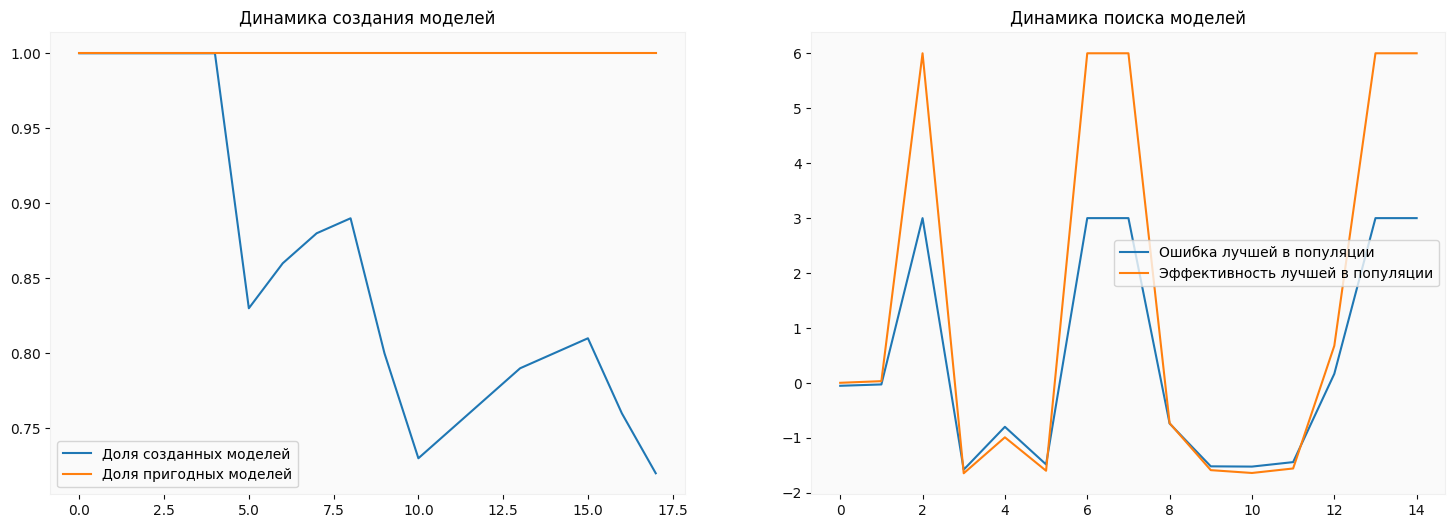


Мегапопуляция 5, эпоха 3
Модели популяции: создано [65, 0.72] брак [25, 0.28]
Модели популяции: пригодны [65, 1.0] не пригодны [0, 0.0]



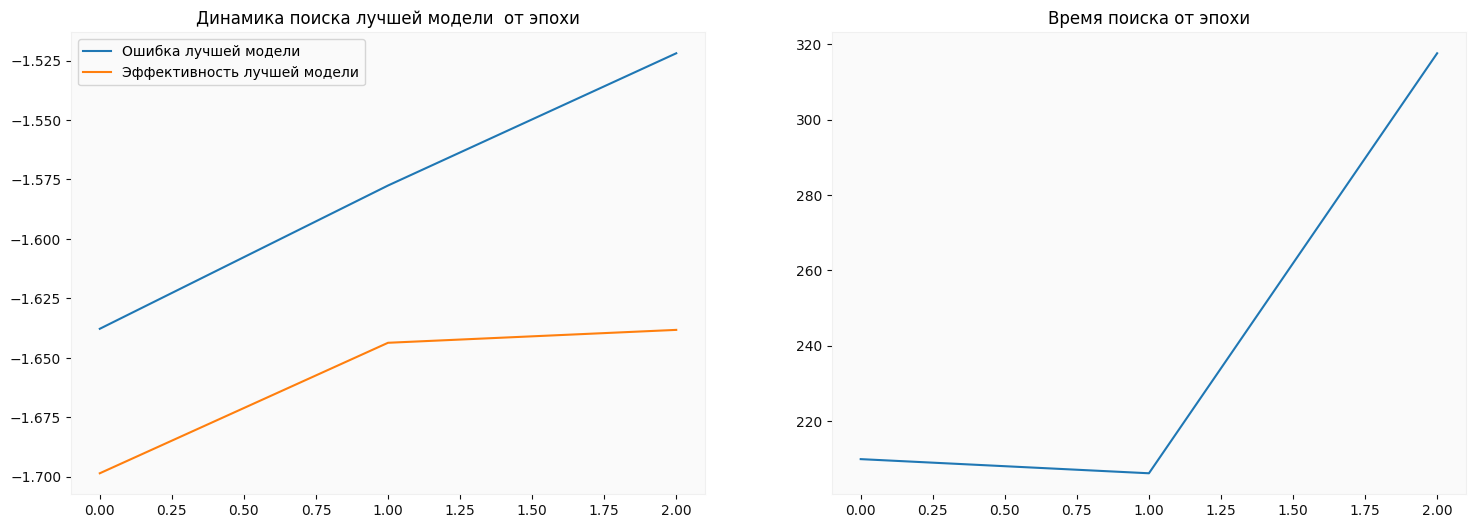


Эпоха 2, точность моделей [[ 0.03006325  0.38816705  0.77196735  1.13266788]
 [ 0.03038769  0.03416748  0.33274402  1.09417293]
 [ 0.03627102  0.03678267  0.03808959  0.1850262 ]
 [ 1.46565378  4.0767008  15.09382088 19.56211045]]
Время на эпоху 317.5808324813843, эффективность моделей [[2.30036676e-02 2.54420860e-01 5.07309853e-01 6.70378930e-01]
 [2.59133353e-02 2.60351293e-02 1.99283860e-01 6.44022638e-01]
 [2.77841304e-02 2.79810987e-02 2.88760183e-02 1.34313127e-01]
 [4.74079879e+00 1.30050424e+01 4.72751658e+01 6.15072425e+01]]
До окончания поиска 0 сек.
К-ко ошибок в длине ботов 0

Мегапопуляция 0 добавляем 3 ботов
Популяция 0, ботов 2
Популяция 0, дополнена до ботов 3
Популяция 0, дополнена до ботов 4
Популяция 0, дополнена до ботов 5
Популяция 0, ботов 5
Мегапопуляция 1 добавляем 3 ботов
Популяция 1, ботов 2
Популяция 1, дополнена до ботов 3
Популяция 1, дополнена до ботов 4
Популяция 1, дополнена до ботов 5
Популяция 1, ботов 5
Мегапопуляция 2 добавляем 4 ботов
Популяция 2, 

In [ ]:
# ВЕРСИЯ КОДА С ПОСЕВОМ и генетикой в создании новых популяций

# Сохраняем массивы лучших моделей на диск
# [[[bot_pop_1],[blockov_list_1],[bot_1]],[[bot_pop_1],[blockov_list_1],[bot_1]]]
directory = 'Генетика/'  # создать папку куда пишет данные этот код

########### посев сетей вначале кода ############################################
# posev = []
# смотри пояснения выше как передать сюда ранее созданные данные
try:
    posev = np.load(directory + 'bestnets.npy', allow_pickle=True)
    if posev.shape == ():  # Если файл существует но пустой
        posev = []
    else:
        posev = posev.tolist()  # Конвертируем numpy array в список
except (FileNotFoundError, IOError):
    posev = []
# если еще нет список моделий, то ввести 0
# или можно вручную списки подать, указав вместо 0, сколько будкт сетей
# последовательно в ответ ввести  листы [bot_pop], [blockov_list], [bot]

# в текстовой ячейке ниже есть 2 сети для посева вручную

########### для подсевания лучших сетей прошлых эпох ###########################
waitnets = 3 # сколько выводим лучших для для изучения и посева
dw = 0.4 # доля лучших с прошлых эпох для подсева
frbest = 2 # как часто подсевыем лучших с прошлых эпох
################################################################################

########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear','relu', 'elu']
# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             #2: 'Recur', # На малом ОЗУ лучше закомитить
             None: 'MIX'
}

################################################################################
q_tyblocks = 8    # макс количество генерируемых блоков для сети
q_lays = 10       # макс количество слоев в блоках
################################################################################
verbouse = 0     # отображать ли обучение
epohs = 3        # Количество эпох для генетического поиска моделей
test_eph = 5     # Количество эпох тестового обучения моделей
################################################################################

################################################################################
n = 5             # количество ботов популяции
p = 6             # количество популяций

dn = 0.3 # доля выживших ботов
dp = 0.3 # доля выживших популяций

dneff = 0.1 # доля выживших ботов по эффективности
dpeff = 0.1 # доля выживших популяций по эффективности

prb_randbot = 0.3 # вероятность появления случайного бота в новой популяции
mutp = 0.4   # Коэфициент мутаций при создании мегабота новой популяции
mutn = 0.45  # Коэфициент мутаций при создании бота новой сети в популяции

dpsurv = 0.8 # доля от выживших ботов популяции используемыех в родителях
dnsurv = 0.8 # доля от выживших ботов мегапопуляции используемыех в родителях
################################################################################


################################################################################

nsurv = max(2,round(dn* n))  # Кол-во выживших ботов мин 2 для родителей
psurv = max(2,round(dp * p)) # Кол-во выживших популяций

nsurv_eff = max(1,round(dneff * n)) # Коли-во выживших ботов поп-ии по эффект.
psurv_eff = max(1,round(dpeff * p)) # Кол-во выживших ботов мегапоп по эффект.

nnew = max(0, n - nsurv - nsurv_eff)  # Кол-во новых ботов
pnew = max(0, p - psurv - psurv_eff)  # Кол-во новых популяций

parents_n = round(nsurv*dnsurv) # выж. боты популяции используемые в родителях
parents_p = round(psurv*dpsurv) # выж. боты мегапопуляции используемые в родит.

sevbest = round(waitnets*dw) # сколько подсеем лучших с прошлых эпох
################################################################################


################################################################################
popul = []         # обнулении популяции
val_p = []         # обнулении точности популяции
# создаем мегопопуляцию популяций ботов
mega_popul = []
mega_info = []
botpop_lst = []

start_time = time.time()

# для посева из определенных моделей нужно создвть лист сетей попримеру
# или ввести 0 при запросе input()
if posev == []:
  posev = posev_net()

for m in range(p):
############# ПОСЕВ ############################################################
    # сеем популяции из листа posev
    if posev != [] and m < len(posev):
        bot_pop = posev[m][0]
        blockov_list = posev[m][1]
        popul = []                 # Создаем пустую популяцию
        popul.append(posev[m][2])  # задаем первого бота популяции из сева
        for i in range(1,n):       # Проходим по всей длине популяции от 1
            # создаем оставшихся случайнонных ботов из сеяного blockov_list
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            bot = maker_blocks.buildblock_bot(blockov_list)
            popul.append(bot)      # добавляем бота в популяцию

    ############################################################################
    # генерируем бота популяции
    else: # если нет посева или если посев менее нужного количества
        # случайно выбираем тип популяции
        type_net =  random.choice(list(style_net.keys()))#
        # инициализируем Set_net на основе заданных парамметров
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        bot_pop = maker_blocks.buildpopulbot(q_tyblocks, q_lays)

        # генерируем из состав блоков из к-ва блоков и слоев
        structure = [np.random.randint(0,bot_pop[1]) for i in range(bot_pop[0])]
        # создаем единый список блоков для популяции
        blockov_list = maker_blocks.sostav_blockov(structure)
        popul = []             # Создаем пустую популяцию
        for i in range(n):     # Проходим по всей длине популяции
            # создаем очередного случайнонного бота на основе blockov_list
            bot = maker_blocks.buildblock_bot(blockov_list)
            popul.append(bot)  # добавляем бота в популяцию

    mega_popul.append(popul) # доб. популяцию в мегапопуляцию
    mega_info.append(blockov_list) # доб. информацию о блоках  в мегапопуляцию
    botpop_lst.append(bot_pop) # доб. мегабота популяции в лист ботов популяций

if posev != []: print(f'Посеено {len(posev)} сетей')

# счетчики
avl_mdl = 0 # счетчик созданных моделей
non_mdl = 0 # счетчик не созданных моделей
ntk_mdl = 0 # счетчик моделей не подходящих под задачу
gd_mdl  = 0 # счетчик моделей пригодных под задачу
################################################################################

################################################################################
# для сбора данных об эффективности обучения от эпохи
ephtime_lst = []
avlmdl_lst  = []
gdmdl_lst   = []
sval_lst    = []
seff_lst    = []
svalp_lst   = []
seffp_lst   = []
bestnets = []
val_best = []
# счетчик ошибок в скрещивании
err_gen = 0
################################################################################

# Пробегаемся по всем эпохам
for it in tqdm(range(epohs), unit ="epohs",  # Пробегаемся по всем эпохам
                   desc ="Пробегаемся по всем эпохам"):
    val_p = []
    eff_p = []
    raw_val_p = []
    raw_eff_p = []
    curr_time = time.time()
    for m in tqdm(range(p), unit ="popul",
                desc ="Проходимся по популяциям"): # проходимся по популяциям
        popul = mega_popul[m]       # берем очередную популяцию
        blockov_list = mega_info[m] # берем информацию и популяции
        bot_pop = botpop_lst[m]     # берем очередного мегабота популяцию
        val = []
        eff = [] #  список для списков по среднему обучению модели в fit()
        for i in range(n): # Проходим по всей длине популяции
            bot = popul[i] # Берем очередного бота

            ########################################
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            # инициализируем класс формирования сети
            regress_model = WildregressModel(INSHAPE)
            # тип модели и номер для отображения
            discription = f'{style_net[bot_pop[2]]}_{i}'
            ###########################################

           #####################################################################
           #               ОЦЕНКА МОДЕЛИ ОТ БОТА ПОПУЛЯЦИИ                     #
           #####################################################################
            try:
              # пробуем создать модель
              gen_model = regress_model(
                                        bot_pop,      # бот_популяции сетей
                                        bot,          # бот парам-в слоев сети
                                        blockov_list, # список имен слоев сети
                                        maker_blocks, # класс построения блоков
                                        # парамметр декоратора
                                        timeout = TIMELIMIT_1,
                                        # время в сек отводимое на создание модели
                                        )
              # если превысили время, то gen_model - просто сообщение
              if type(gen_model) == str:
                  print(gen_model)
                  testing = False
              else: # значит модель создалась
                  train_param = np.sum([tf.keras.backend.count_params(w) \
                                        for w in gen_model.trainable_weights])
                  print(discription + f' c {train_param} обучаемыми параметрами - создалась')
                  testing = True
                  avl_mdl+=1

              # Вычисляем точность текущего бота
              try:
                  if testing:
                      # оптимизатор
                      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
                      # функция потерь
                      loss = tf.keras.losses.MSE
                      # оценка по времени и смешанной точности нашей модели
                      result = evaluate_model(
                      # парамметр от декоратора
                      timeout =  TIMELIMIT_2,  # время в сек отводимое на оценку
                      # собственные парамметры функции
                      model = gen_model,           # тестируемая модель
                      y_scaler = Y_SCAILER,        # обученный скейлер для y
                      train_gen = train_datagen,   # генератор данных для обучения
                      val_gen = val_datagen,       # генератор данных для проверки
                      ep = test_eph,               # эпох обучения
                      verb = verbouse,             # отображать ли обучение
                      optimizer = optimizer,       # оптимизатор
                      loss = loss,                 # функция потерь
                      channels = np.arange(PREDICT_LAG),# Отображение сводки модели
                      predict_lag = PREDICT_LAG    # На сколько шагов предсказание
                      )

                      # выводим результат оценки
                      # если превысили время, то gen_model - просто сообщение
                      if len(result) > 2:
                        print(result)
                        ntk_mdl+=1
                        f = 300
                        tlrn = 300

                      else: # значит модель протестировалась
                        f = result[0]
                        tlrn = result[1]
                        print(discription + ' - подошла под задачу')
                        gd_mdl+=1

                      # удаляем модель
                      del(gen_model)
                      # чистим память
                      gc.collect()

                  else:
                    print(discription + ' - слишком долго создавалась')
                    ntk_mdl+=1
                    f = 600
                    tlrn = 600

              except Exception:
              # если не создалась то пишем плохую точность
                  print(discription + ' - не подошла под задачу')
                  ntk_mdl+=1
                  f = 800
                  lrn = 800

            except Exception:
                # если не создалась то пишем плохую точность
                print(discription + ' - не создалась')
                non_mdl+=1
                f = 1000
                tlrn = 1000
            if f in (600, 800, 1000): print('Модель отбракована')
            elif f == 300: print('Модель долго учится')
            else:
              print(f'Оценка модели {round(f, 5)}, тестовое обучение на {test_eph} эпохах составило {round(tlrn, 2)}сек. ')
            print()
            val.append(f)       # Добавляем полученное значение в список val
            eff.append(tlrn*f) # сохраняем время эффективность обучения модели
           #####################################################################

        ########################################################################
        # базовый список точновстей мегапопуляции
        raw_val_p.append(val)
        # сортируем val
        sval = sorted(val, reverse=0)
        # базовый список сортированных точновстей популяций
        val_p.append(sval)
        # для сбора динамики точности от популяции
        sval_lst.append(np.log10(sval[0]))


        # базовый список эффекивностей мегапопуляции
        raw_eff_p.append(eff)
        # сортируем по эффективности
        seff = sorted(eff, reverse=0)
        # базовый список сортированных эффекивностей популяций
        eff_p.append(seff)
        # для сбора динамики эффективности от популяции
        seff_lst.append(np.log10(seff[0]))
        ########################################################################

        clear_output()
        ########################################################################
        # сбор|вывод данных эффективности поиска от популяции к популяции
        try:
            avlmdl = round(avl_mdl/(avl_mdl+non_mdl),2)
            avlmdl_lst.append(avlmdl)
            nonmdl = round(non_mdl/(avl_mdl+non_mdl),2)
            gdmdl = round(gd_mdl/(avl_mdl),2)
            gdmdl_lst.append(gdmdl)
            ntkmdl = round(ntk_mdl/(avl_mdl),2)
            # Показываем ход генитеческого поиска
            show_pocess_1(avlmdl_lst, gdmdl_lst, sval_lst, seff_lst)
            print()
            print(f'Мегапопуляция {m}, эпоха {it+1}')
            print(f'Модели популяции: создано {[avl_mdl,avlmdl]} брак {[non_mdl,nonmdl]}')
            print(f'Модели популяции: пригодны {[gd_mdl,gdmdl]} не пригодны {[ntk_mdl,ntkmdl]}')
            print()
        except:
            pass

    ############################################################################
    # сбор и вывод данных для оценки эффективности поиска от эпохи
    # сорт. список точностей мегапопуляции отсортированые точностями популяций
    sval_p = sorted(val_p, key=lambda x: x[0])
    # сортируем список точностей мегапопуляции по эффективности
    seff_p = sorted(eff_p, key=lambda x: x[0])
    eph_time = time.time() - curr_time
    # собираем для контроля поиска и отображения
    svalp_lst.append(np.log10(sval_p[0][0]))
    seffp_lst.append(np.log10(seff_p[0][0]))
    ephtime_lst.append(eph_time)

    ############################################################################
    # Показываем ход генитеческого поиска
    if it > 1: show_process_2(svalp_lst, seffp_lst, ephtime_lst)

    # Показыааем результаты лучших ботов
    acc_models = np.array(sval_p)[:4,:4]
    eff_models = np.array(seff_p)[:4,:4]
    to_end = round(np.mean(ephtime_lst)*(epohs-it-1))
    print(f'Эпоха {it}, точность моделей {acc_models}')
    print(f'Время на эпоху {eph_time}, эффективность моделей {eff_models}')
    print(f'До окончания поиска {to_end} сек.')
    print(f'К-ко ошибок в длине ботов {err_gen}')
    print()
    ############################################################################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst, ephtime_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # то возобновить код с момента создания новых мега популяций и популяций
    ############################################################################

    ############################################################################
    #   ФОРМИРОВАНИЕ НОВЫХ ПОПУЛЯЦИЙ НА ОСНОВЕ ПОЛУЧЕННЫХ ОЦЕНОК               #
    ############################################################################
    newmega_popul = []
    newmega_info  = []
    newbotpop_lst = []
    # записываем данные лучших по точночти сетей
    # проходимся по выжившим мега-популяциям
    for m in range(psurv):
        # индекс sval из списка сортированных точностей
        idx_p = val_p.index(sval_p[m])
        # получаем оценка популяции idx_p
        val = sorted(raw_val_p[idx_p], reverse=0)

        blockov_list = mega_info[idx_p] # берем информацию
        bot_pop = botpop_lst[idx_p]     # берем мегабота популяцию
        popul = []
        # записываем отобранных ботов в популяции
        for i in range(nsurv):
            # индекс бота лучших в первичном списке val_p
            bot_id = val_p[idx_p].index(val[i])

            # Берем очередного бота
            bot = mega_popul[idx_p][bot_id]
            # пополяем популяцию ботом
            popul.append(bot)
        # пополяем мегапопуляцию
        newmega_popul.append(popul)
        newmega_info.append(blockov_list)
        newbotpop_lst.append(bot_pop)


    # записываем эффективных  ботов популяций
    for m in range(psurv_eff):
        # индекс из списка эффективных
        idx_p = eff_p.index(seff_p[m])
        # эффективность  популяция idx_p
        seff = sorted(raw_eff_p[idx_p], reverse=0)

        blockov_list = mega_info[idx_p] # берем информацию
        bot_pop = botpop_lst[idx_p]     # берем мегабота популяцию
        popul = []
        # записываем отобранных ботов в популяции
        for i in range(nsurv_eff):
            # индекс бота эффекивных в первичном списке eff_p
            bot_id = eff_p[idx_p].index(seff[i])

            # Берем очередного бота
            bot = mega_popul[idx_p][bot_id]
            # пополяем популяцию ботом
            popul.append(bot)
        # пополяем мегапопуляцию
        newmega_popul.append(popul)
        newmega_info.append(blockov_list)
        newbotpop_lst.append(bot_pop)


    # идем по отобранным популяциям точных и эффективных
    for m in range(psurv+psurv_eff):
        #newpopul = []
        popul = newmega_popul[m]
        blockov_list = newmega_info[m]
        bot_pop = newbotpop_lst[m]
        add_n = n - len(newmega_popul[m])
        print(f'Мегапопуляция {m} добавляем {add_n} ботов')

        # берем ген определяющий тип сети популяции
        type_net = bot_pop[2]
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)

        # инициализируем класс структуры блоков на основе параметров сети
        maker_blocks = Make_blocks(choosing_net)
        bots_poprandom = [maker_blocks.buildblock_bot(blockov_list) \
                         for i in range(add_n)]

        # Проходимся в цикле add_n-раз
        real_parents = min(len(popul), parents_n)
        print(f'Популяция {m}, ботов {len(newmega_popul[m])}')
        # Проходимся в цикле add_n-раз
        for i in range(add_n):
            idxp =  np.random.randint(0, len(popul), real_parents)
            if len(popul) == 1: bots_parent = [popul[0]]
            else: bots_parent = [popul[b] for b in idxp]

            newbot = []  # Создаем пустой список под значения нового бота
            # Пробегаем по всей длине бота
            for j in range(len(bots_parent[0])):
              if len(bots_parent[0]) == 1: k=0
              else: k = np.random.randint(0, real_parents)
              # есои боты разной
              try:
                 x = bots_parent[k][j]
              except:
                 x = bots_poprandom[k][j]
                 err_gen+=1
                 print(f'Бот другой длины, берем случайный ген, к-ко ошибок {err_gen}')
              # С вероятностью mutn устанавливаем значение бота
              if (np.random.random() < mutn):
                k = np.random.randint(0, add_n)
                x = bots_poprandom[k][j]

              newbot.append(x)      # Доб. очередное значение в нового бота
            newmega_popul[m].append(newbot) # Доб. бота в новую популяцию
            # Для контроля кода - не разрастается ли популяция из-за ошибки
            print(f'Популяция {m}, дополнена до ботов {len(newmega_popul[m])}')
        # Для контроля кода - не разрастается ли популяция из-за ошибки
        print(f'Популяция {m}, ботов {len(newmega_popul[m])}')

        ########## пересохраняем каждую эпоху данные ###########################
        saver([newmega_popul, newbotpop_lst, newmega_info], directory)
        # это можно взять в свернутый лист автопосев на случай сбоя колаба
        # то возобновить код с момента создания новых мега популяций и популяций
        ########################################################################

    ##################### ПОДСКАЗКА ДЛЯ УЛУЧШЕНИЯ ##############################
    # Можно тут организовать тригер, чтобы, имея сохраненными newmega_popul,
    # newbotpop_lst, newmega_info на диске, запускать цихл не вначале, а с этого
    # момента, загрузив вначале их в код.
    ############################################################################

    ########### Сортировка и сохранение лушх сетей #############################
    # определяем к-во возможных сетей real_bestnets при малых к-вах
    real_bestnets = min(len(newmega_popul[0]), waitnets)
    # получаем индексы  лучших сетей по всем мегапопуляциям
    idxs, sval_best = get_idxbest(sval_p, real_bestnets)
    # получаем спиок лучших сетей по всем мегапопуляциям на эпохе
    newbestnets = get_bestnets(idxs, newbotpop_lst, newmega_info, newmega_popul)
    # получаем список лучших сетей
    for i in range(real_bestnets): bestnets.append(newbestnets[i])
    # объединяем списки
    val_best = np.hstack((val_best,sval_best))
    # получаем индексы для сортировки
    idx = np.argsort(val_best)[:real_bestnets]
    val_best = val_best[idx]
    bestnets = [bestnets[i] for i in idx]
    # сохраняем список лучших сетей
    np.save(directory + 'bestnets.npy',  np.array(bestnets, dtype=object))
    ############################################################################

    ############# ПОДСЕВ лучшх сетей с прошлых эпох ############################
    if (it > 1 and  it % frbest == 0) and (p - psurv - psurv_eff - sevbest) > 0:
        pbest = sevbest
        posev_lst = bestnets[:pbest]
        # сеем популяции из листа posev
        for m in range(pbest):
            bot_pop = posev_lst[m][0]
            blockov_list = posev_lst[m][1]
            popul = []  # Создаем пустую популяцию
            # задаем первого бота популяции из сева
            popul.append(posev_lst[m][2])
            # Проходим по всей длине популяции от 1
            for i in range(1,n):
                # берем ген определяющий тип сети популяции
                type_net = bot_pop[2]
                choosing_net = Set_net(type_net, activ_lays, activ_out,
                                       neiro_out)
                # иници/ класс структуры блоков на основе парраметров сети
                maker_blocks = Make_blocks(choosing_net)
                # создаем оставшихся случайнонных ботов из сеяного blockov_list
                bot = maker_blocks.buildblock_bot(blockov_list)
                popul.append(bot)      # добавляем бота в популяцию
            # добавляем популяцию в мегапопуляцию
            newmega_popul.append(popul)
            # добавляем информацию о блоках  в мегапопуляцию
            newmega_info.append(blockov_list)
            # добавляем мегабота популяции в лист ботов популяций
            newbotpop_lst.append(bot_pop)
        print(f'Посеено {len(posev_lst)} сетей из лучших прошлых эпох')
    else:
        pbest = 0

    ############################################################################
    #  досоздаем ботов к отобранным популяциям основе скрещиваний и мутаций   #
    ############################################################################
    # сколько  создаем новых популяций от родителей
    pneweph = max(0, pnew - pbest)  # Кол-во новых популяций
    if pneweph:
        # случайно выбираем тип сети
        type_net =  random.choice(list(style_net.keys()))
        # создаем новых ботов в эту популяцию
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        bots_poprandom = [maker_blocks.buildpopulbot(q_tyblocks, q_lays) \
                          for i in range(pnew - pbest)]
        # контроль к-ва родителей при малых популяциях
        real_parents_p = min(len(newbotpop_lst), parents_p)
        # создаем популяции от родителей
        for m in range(pneweph):
            idxp =  np.random.randint(0, psurv + psurv_eff - 1, real_parents_p)
            # контроль для малого к-ва мегапопуляций
            if len(newbotpop_lst) == 1: bots_popparent = newbotpop_lst[0]
            else: bots_popparent = [newbotpop_lst[i] for i in idxp]

            # Создаем пустой список под значения нового мегабота
            newbot_pop = []
            # Получаем случайное число в диапазоне от 0 до 1
            if np.random.random() < prb_randbot:
                k = np.random.randint(0, pneweph)
                # берем совсем случайный бот пупуляции
                bot_pop = bots_poprandom[k]

            else:  # создаем бот пупуляции генетикой
                # Пробегаем по всей длине бота
                for j in range(len(bots_popparent[0])):
                    if len(bots_popparent[0]) == 1: k=0
                    else: k = np.random.randint(0, real_parents_p-1)
                    x = bots_popparent[k][j]

                    # С вер. mutp ставим значение бота из случайного мегабота
                    # только не трогаем тип сети мутацией
                    if np.random.random() < mutp and j!=2:
                        k = np.random.randint(0, pneweph)
                        x = bots_poprandom[k][j]
                    newbot_pop.append(x)  # Доб. ген в нового мегабота
                bot_pop = newbot_pop      # бот популяции создан

            # генерируем из состав блоков популяции
            structure  = [np.random.randint(0, bot_pop[1]) for i in \
                          range(bot_pop[0])]
            # создаем единый список блоков для популяции
            blockov_list = maker_blocks.sostav_blockov(structure)

            popul = [] # Создаем пустую популяцию
            # Проходим по всей длине популяции
            for i in range(n):
                # создаем очередного случайнонного бота на основе blockov_list
                bot = maker_blocks.buildblock_bot(blockov_list)
                popul.append(bot)  # доб. бота в популяцию

            newmega_popul.append(popul)       # доб. популяцию в мегапопуляцию
            newmega_info.append(blockov_list) # доб. информацию о блоках
            newbotpop_lst.append(bot_pop)     # доб. мегабота
    # Для контроля кода - не разрастается ли популяция из-за ошибки
    print(f'Всех популяций {len(newmega_popul)}, ботов {len(newmega_popul[0])}')

    # перезаписываем информацию
    mega_popul = newmega_popul
    mega_info = newmega_info
    botpop_lst = newbotpop_lst
    ############################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst, ephtime_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # и возобновить код с момента создания новых мега популяций и популяций
    ############################################################################
    # удаляем лишнее
    del(newmega_popul)
    del(newmega_info)
    del(newbotpop_lst)
    # чистим память
    gc.collect()
finish_time = time.time() - start_time
print(f'Общее время подбора за {epohs} эпох по {p*n} моделей составило {finish_time}')
print(f'К-ко ошибок в длине ботов {err_gen}')

ПРИМЕР ДЛЯ ПОСЕВА ВРУЧНУЮ:

    # вариант из презентации
    bot_pop = [7, 1, None, 1, 16, 7, 0, 0, 0, 0]
    setblockov = [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    bot = [[], [], [64, 4, 'same'], [128], [], [], []]

    # иной вариант
    bot_pop = [7, 2, 1, 1, 8, 2, 1, 2, 2, [0, 4, 1, 2]]
    setblockov = [[], ['Conv1D'], ['Conv1D'], [], [], ['Conv1D'], []]
    bot = [[], [64, 4, 'same'], [32, 5, 'valid'], [], [], [32, 3, 'valid'], []]
    

In [ ]:
gc.collect()

43

# После генетики

## Генерация нейронки

In [ ]:
#directory = '..папка куда сохранял код выше../'  # куда пишет данные код
directory = 'Генетика/'  # куда пишет данные код
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear', 'relu', 'elu']

# загружаем список парамметров лучших сетей
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n
set_models = getnetfrombest(save_nets.tolist(), activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)


In [ ]:
k = 0 # указываем индекс от 0 до n-1 для выбора модели
good_model = set_models[k]
good_model.call = tf.function(good_model.call)

# Отображение сводки модели
good_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 25, 106)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 64)    │      6,848 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 25, 64)    │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25, 128)   │      8,320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 25)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 25)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 128, 25)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 64, 25)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_3[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │        170 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,106 (78.54 KB)

 Trainable params: 20,106 (78.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install pydot

In [ ]:
# дерево модели
tf.keras.utils.plot_model(good_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
k = 1 # указываем индекс от 0 до n-1 для выбора модели
good_model_1 = set_models[k]
good_model_1.call = tf.function(good_model_1.call)
#k = 2 # указываем индекс от 0 до n-1 для выбора модели
#good_model_2 = set_models[k]
#good_model_2.call = tf.function(good_model_2.call)

# Отображение сводки модели
good_model_1.summary()
#good_model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 25, 106)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 25, 64)    │      6,848 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25, 64)    │      4,160 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 25, 128)   │      8,320 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 64, 25)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 64, 25)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 128, 25)   │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_4[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_5[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_6[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 64, 25)    │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 75)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_7[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        608 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 33)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        170 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,106 (78.54 KB)

 Trainable params: 20,106 (78.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# дерево модели
tf.keras.utils.plot_model(good_model_1, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Обучение сгенерированной модели

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
# очистка ОЗУ
clear_ozu = GarbageCollectorCallback()

### Вариант 1 - Базовое

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() # MSE #
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)


# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=17,
    mode='min',
    restore_best_weights=True)


In [ ]:
start = time.time()
# обучение модели
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, reduce_lr, clear_ozu],
                          verbose = 1)

end = time.time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0677 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0025 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0016 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0017 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0011 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0021 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.3740e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 9/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0017 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 

In [ ]:
start = time.time()
# обучение модели
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, reduce_lr, clear_ozu],
                          verbose = 1)

end = time.time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.4794e-04 - val_loss: 0.0011 - learning_rate: 1.6777e-04
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.3245e-04 - val_loss: 0.0013 - learning_rate: 1.6777e-04
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.5249e-04 - val_loss: 0.0012 - learning_rate: 1.6777e-04
Epoch 4/150
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5939e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.6153e-04 - val_loss: 0.0011 - learning_rate: 1.6777e-04
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.6115e-04 - val_loss: 0.0011 - learning_rate: 1.3422e-04
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.5347e-04 - val_loss: 0.0010 - learning_rate: 1.3422e-04
Epoch 7/150
59/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1955e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
70/70 ━━━━

In [ ]:
good_model.save(directory + 'good_model.keras')

### Вариант 2 - используя CyclicalLearningRate и SGD

In [ ]:
!pip install --upgrade tensorflow-addons
!pip install tfa-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 8.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
INIT_LR = 1e-3
MAX_LR = 1e-2

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)

# функция потерь
loss = tf.keras.losses.Huber() #MSE #
good_model.compile(optimizer = optimizer, loss = loss)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience= 10,
    mode='min',
    restore_best_weights=True)

In [ ]:
from time import time
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.8928e-04 - val_loss: 0.0010
Epoch 2/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 6.2923e-04 - val_loss: 0.0010
Epoch 3/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.5675e-04 - val_loss: 0.0010
Epoch 4/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.7858e-04 - val_loss: 0.0010
Epoch 5/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.2855e-04 - val_loss: 0.0010
Epoch 6/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.8735e-04 - val_loss: 0.0010
Epoch 7/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.8515e-04 - val_loss: 0.0010
Epoch 8/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.4008e-04 - val_loss: 0.0010
Epoch 9/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.6140e-04 - val_loss: 0.0010
Epoch 10/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.1731e-04 - val_loss: 0.0010
Epoch 11/150
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.7762e-04 - val_loss: 0.0010
Epoch 11

### Вариант 3 - используя взвешанное MSE
пример https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b

In [ ]:
len_period = PREDICT_LAG

weights = []
for i in range(len_period):
  w = (len_period-i)/len_period

  weights.append(w)

weights

[1.0, 0.8, 0.6, 0.4, 0.2]

In [ ]:
def weight_mse(w):

    def custom_mse(y_true, y_pred, w = w):
        # calculating squared difference between target and predicted values
        loss = tf.keras.backend.square(y_pred - y_true)  # (batch_size, 2)

        # multiplying the values with weights along batch dimension
        loss*= w         # (batch_size, 2)

        # summing both loss values along batch dimension
        loss = tf.keras.backend.mean(loss, axis=-1)        # (batch_size,)
        return loss
    return custom_mse

In [ ]:
import tensorflow_addons as tfa
INIT_LR = 1e-4
MAX_LR = 1e-3

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)
# функция потерь
loss = weight_mse(weights)
good_model.compile(optimizer = optimizer, loss = loss)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience= 10,
    mode='min',
    restore_best_weights=True)

In [ ]:
from time import time
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 200,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.6646e-04 - val_loss: 0.0010
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.7525e-04 - val_loss: 0.0010
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.6216e-04 - val_loss: 0.0010
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.7919e-04 - val_loss: 0.0010
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.1109e-04 - val_loss: 0.0010
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.6025e-04 - val_loss: 0.0010
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.7243e-04 - val_loss: 0.0010
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.8071e-04 - val_loss: 0.0010
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.6760e-04 - val_loss: 0.0010
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.2576e-04 - val_loss: 0.0010
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.3739e-04 - val_loss: 0.0010
Epoch 11

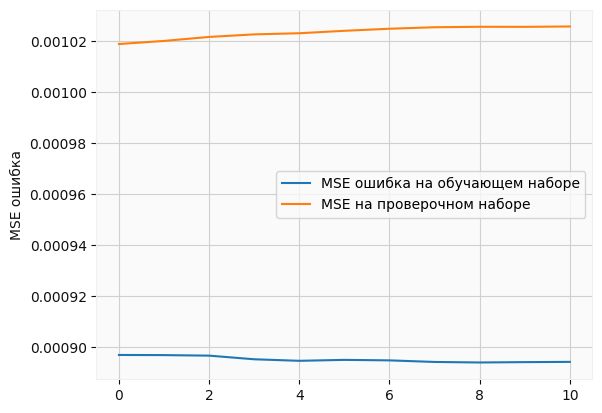

In [ ]:
plt.plot(history.history['loss'],
         label='MSE ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='MSE на проверочном наборе')
plt.ylabel('MSE ошибка')
plt.legend()
plt.show()

## Оценка модели на VAL данных

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


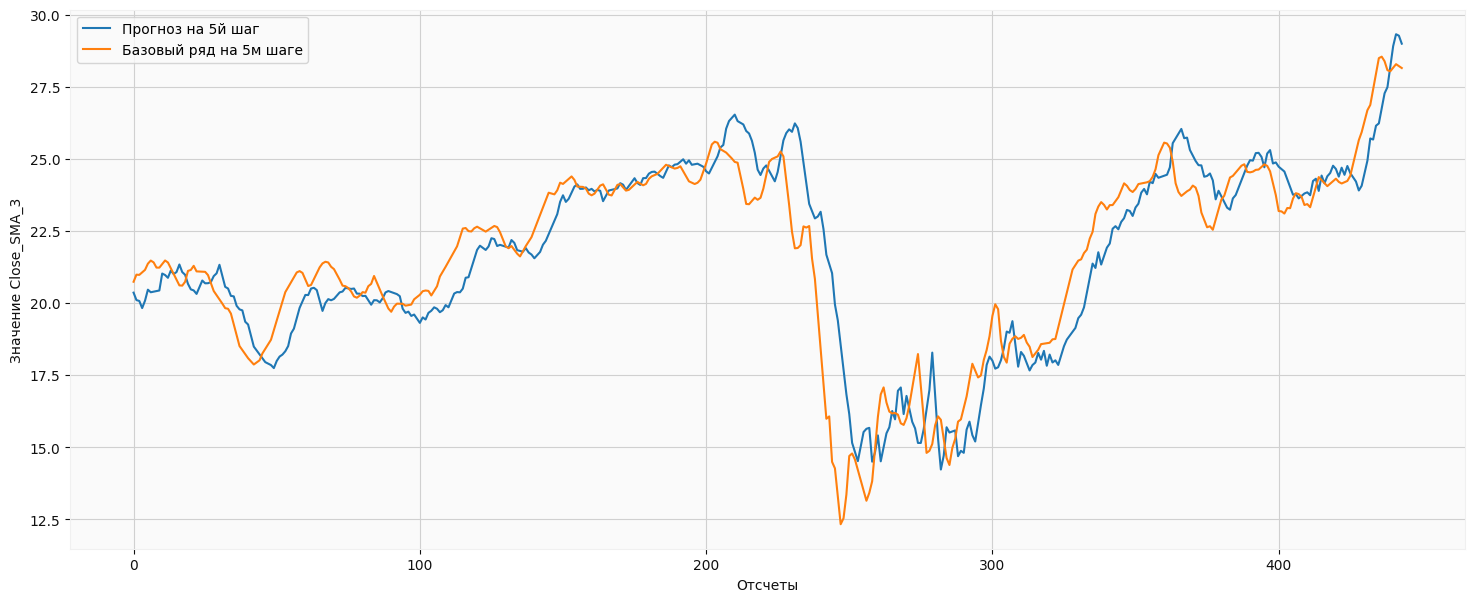

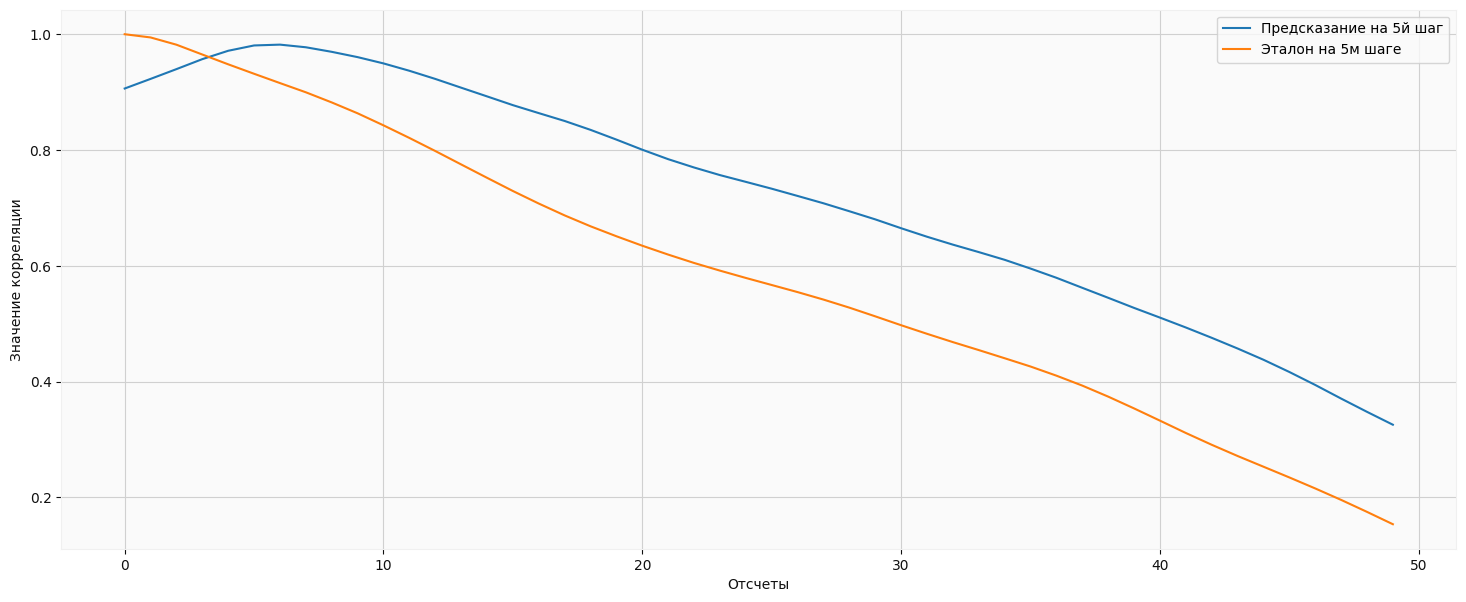

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(good_model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные

# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [4],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,     # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

## Тест модели на TEST данных

### Готовим данные из df_test

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
x_test = X_SCAILER.transform(df_test[TRAIN_COLUMNS][: - PREDICT_LAG + 1])
print(x_test.shape)
# Для подготовки y_test на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
y_test = future_sequence(df_test[PRED_PRICE], PREDICT_LAG)

# если берем логорифм
if MAKE_LOG:
  y_test = np.log(y_test)
print(y_test.shape)

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
y_test = Y_SCAILER.transform(y_test)
print(y_test.shape)

(496, 106)
(496, 5)
(496, 5)


In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
TestDataGen = TSG(x_test, y_test,        # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_test))  # Размер batch будет равен длине нашей выборки

XTEST, YTEST = [], []
for i in range(len(TestDataGen)):
  x_batch, y_batch = TestDataGen[i]
  XTEST.append(x_batch)
  YTEST.append(y_batch)

XTEST = np.array(XTEST)[0]
YTEST = np.array(YTEST)[0]
print(XTEST.shape,YTEST.shape)

(471, 25, 106) (471, 5)


### Делаем оценку test данных

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


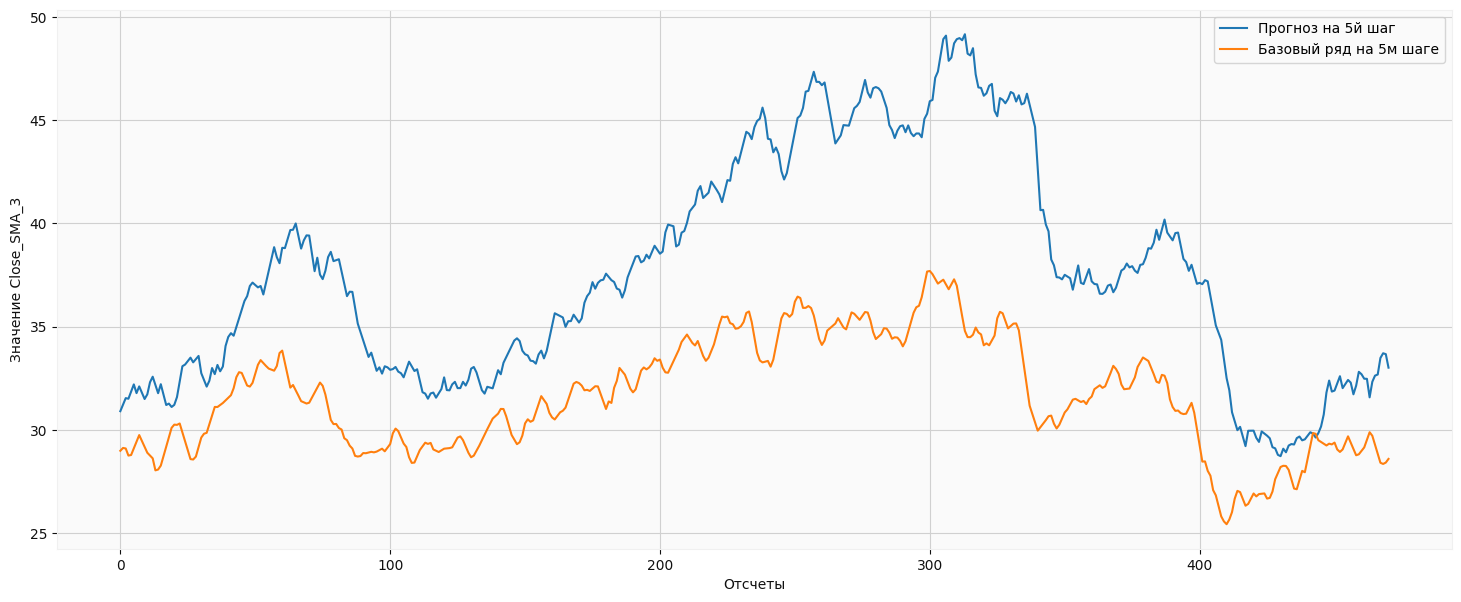

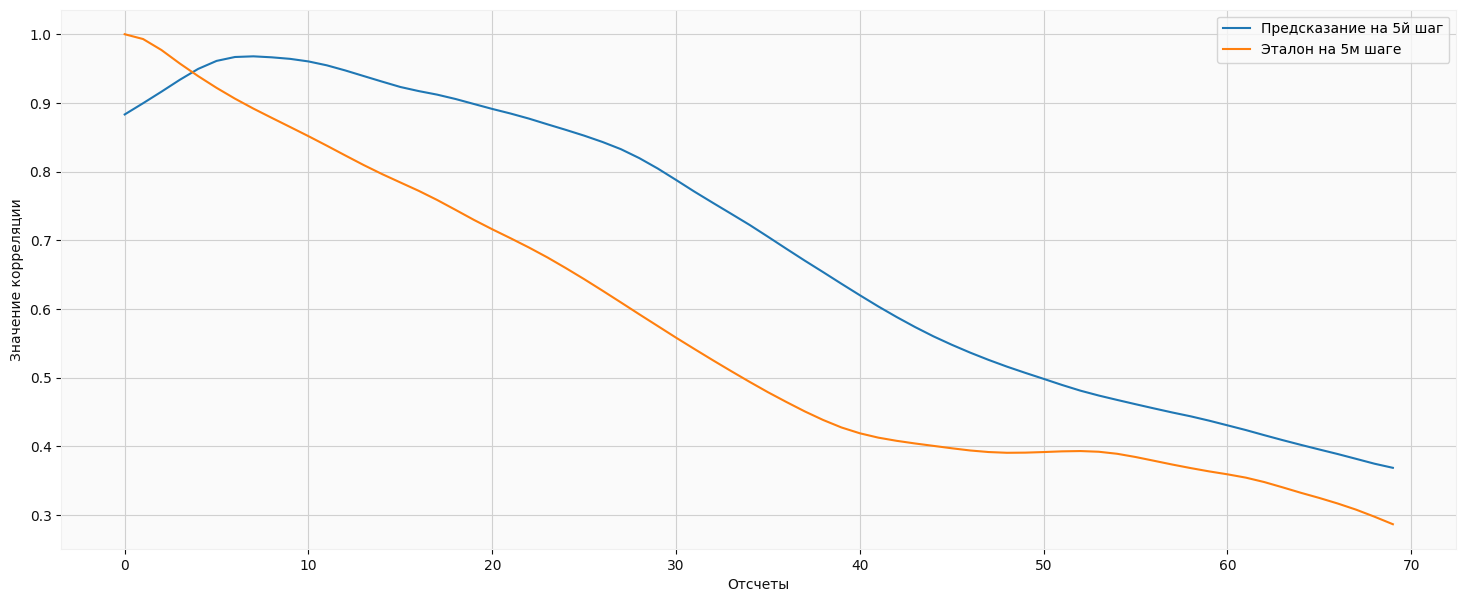

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_test, y_true_test) = get_scalepred(good_model, XTEST, YTEST,
                                           Y_SCAILER) # Прогнозируем данные


# Отображаем графики
show_predict(0,                     # начало периода
             y_true_test.shape[0],  # конец периода
             [4],                   # по предсказанию на какие шаги отрисовываем
             y_pred_test,           # предчказанные цены
             y_true_test,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],              # по предсказанию на какие шаги отрисовываем корреляцию
          70,               # на сколько шагов предсказание
          y_pred_test,      # предчказанные цены
          y_true_test       # реальные цены
          )

### Смотрим цены и предсказываемое

некоторые ссылки, что погли отрисовать:
- https://medium.com/@chris_42047/discover-the-awesome-power-of-mplfinance-python-tutorial-ea756975c77c
- https://github.com/matplotlib/mplfinance/issues/181
- https://stackoverflow.com/questions/70805395/how-do-i-set-the-tick-and-label-colours-in-mplfinance

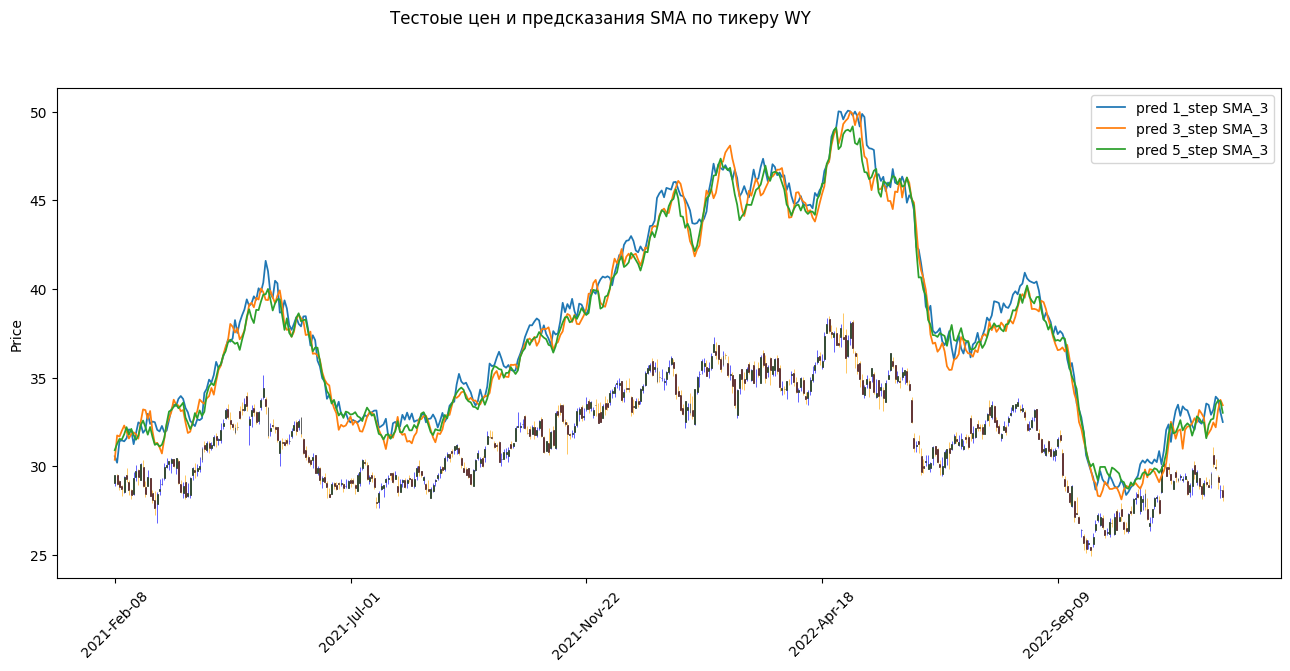

In [ ]:
# индексы шагов вперед
show_steps = (0, 2, 4)

# добавленые графики и названия их
add_pls = {f'pred {step+1}_step {TYPE_PRED}_{WIND_PRED}': mpf.make_addplot(y_pred_test[:, step]) for step in show_steps}

# название всего графика
title = f'Тестоые цен и предсказания {TYPE_PRED} по тикеру {tiker}'

# стиль отрисовки
market_colors = mpf.make_marketcolors(
                               up='green',
                               down='red',
                               edge='black',
                               wick={'up': 'blue', 'down': 'orange'},
                               volume='gray',
                               ohlc='black')
my_style = mpf.make_mpf_style(marketcolors=market_colors)

df2show = df_for_mpf(df_test[DEPTH: - PREDICT_LAG + 1],
                     df_tiker[-test_size:], ADD4MPF)

# отрисовываем графиков
fig, ax = mpf.plot(df2show, # датафрейм
                    addplot= list(add_pls.values()),  # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legend_handles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()

### Смотрим фрагмент

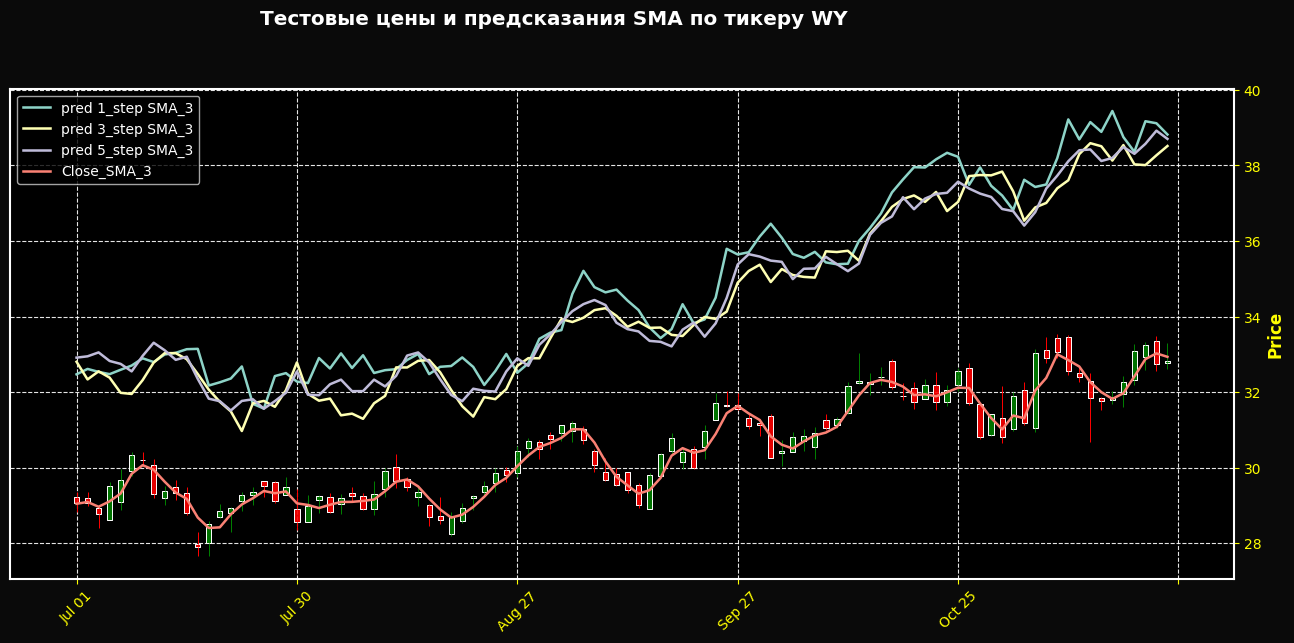

In [ ]:
# временной фрагмент
start = 100
end = 200

# индексы шагов вперед
show_steps = (0, 2, 4)

# добавленые графики и названия их
add_pls = {f'pred {step+1}_step {TYPE_PRED}_{WIND_PRED}': mpf.make_addplot(y_pred_test[:, step][start: end]) for step in show_steps}
add_pls.update({f'{PRED_PRICE}': mpf.make_addplot(df_test[DEPTH: - PREDICT_LAG + 1][PRED_PRICE][start: end])})

# название всего графика
title = f'Тестовые цены и предсказания {TYPE_PRED} по тикеру {tiker}'

my_style = mpf.make_mpf_style(base_mpf_style='mike',
                              base_mpl_style='dark_background',
                              marketcolors=mpf.make_marketcolors(up='g',down='r',
                                                                 edge='white',
                                                                 wick={'up':'g','down':'r'},
                                                                 volume='gray',
                                                                 ohlc='white'),
                              gridcolor='white',
                              gridstyle="--",
                              rc={'xtick.color':'yellow',
                                  'ytick.color':'yellow',
                                  'axes.labelcolor':'yellow'
                                 }
                             )

# отрисовываем графиков
fig, ax = mpf.plot(df2show[start: end],  # датафрейм
                    addplot= list(add_pls.values()),   # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legend_handles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()

# ЧТО ДЕЛАТЬ?




In [ ]:
COMIS = 0.002

In [ ]:
# функция определяет "что делать" и на сколько из остатков денег/акций
def buyorsale(predict):
    '''
    Функция определяет класс действия на основе
    вектора предсказаний predict
    input:
    predict - вектора предсказаний
    return:
    класс действия -
                    0 - ничего не делать
                    1 - покупать
                    2 - продавать

    уверенность в действии
    '''
    dif_buy = 0
    dif_sell = 0
    len_period = len(predict)
    i_buy = len_period
    i_sell = len_period
    for i in range(len_period-1):
        for j in range(len_period-1):
            dif = predict[j]-predict[i]

            if j > i and dif > dif_buy:
                dif_buy = dif
                i_buy = i  # момент продажи

            if j > i and dif < dif_sell:
                dif_sell = dif
                i_sell = i  # момент покупки
    dif_buy = abs(dif_buy)
    dif_sell = abs(dif_sell)
    #print(i_sell, dif_sell)
    #print( i_buy, dif_buy)
    # выводим "что делать?" и с каким коэф-том
    # коэф-т покупки зависит от соот-я выгод от продажи и покупки
    # на отрезке будущем
    if dif_buy == 0 and dif_sell == 0:
        return 0, 0  # спим

    elif  i_buy == 0 and i_buy != i_sell:
          # даем вес dif_sell будущему взависимости от удаленности
          dif_sell_prob = dif_sell*(len_period-i_sell)/len_period
          # сравниваем взвешанную выгоду от действий типа short в дальнем будащем
          # с выгодой от действий для типа long на ближайшем шаге
          if dif_buy > dif_sell_prob:
            # определяем уверенность в покупке от сравнения dif_sell_prob и dif_buy
            force = 1 - dif_sell_prob/dif_buy
            return 1, force  # покупаем
          else:
            return 0, 0  # спим

    elif  i_sell == 0 and i_sell != i_buy:
        # даем вес dif_buy будущему взависимости от удаленности
        dif_buy_prob = dif_buy*(len_period-i_buy)/len_period
        # сравниваем взвешанную выгоду от действий типа long в дальнем будащем
        # с выгодой от действий для типа short на ближайшем шаге
        if dif_sell > dif_buy_prob:
            # определяем уверенность в продаже от сравнения dif_buy_prob и dif_sell
            force = 1 - dif_buy_prob/dif_sell
            return 2, force  # продаем
        else:
          return 0, 0   # спим
    else:
        return 0, 0 # спим



def prepare_data(df_in: pd.DataFrame,
                 depth:int,
                 scaler: object):
    # обогащаем данные ранее созданной функцией
    ds = data_indicators(df_in, DIFFBACK, SET_WIND, FEATURES)
    # обогащаем данные ранее созданной функцией
    ds = add_from_datetime(ds, add_classdays = False)
    # переводим Volume в Log_Volume в df_data
    ds['Log_Volume'] = np.log(df_in['Volume'])
    # Удаление строк с неполными данными
    ds = clean_dataset(ds)
    # оставляем на глубину depth и только нужные колонки
    x_data = ds[TRAIN_COLUMNS][-depth:].values
    # нормализуем
    x_data = scaler.transform(x_data)
    # выводим с добавлением измерения по axis=0
    return np.expand_dims(x_data, axis=0)



def making_signals(past_df: pd.DataFrame,
                    check_df: pd.DataFrame,
                    pred_lag: int,
                    model: object,
                    control_enter = False,
                    stop_loss = 1.,
                    use_force_action = False,
                    show_unique_signals = True,
                    ):
    """
    Args:
        past_df (pd.DataFrame) - прошлые OHCL данные до тестируемых
        check_df (pd.DataFrame) - тестируемые OHCL данные
        pred_lag: int - шаг предсказания
        model (class) - ранее обученная модель
        control_enter (bool) - контролировать ли вход в сделку
        stop_loss (float) - уровень падения цены (от 0 до 1) при которм нужно продать
        use_force_action (bool): False - выводим чистые действия,
                                 True - выводим действия с учетом уверенности,
        show_unique_signals (bool) - показать ли состав чистых действий

    Return:
         df_signal(pd.DataFrame) - копия OHCL датафрейма из check_df с колонкой Signal
    """
    # сбор действий
    all_actions = []
    # сбор уверенности действия
    force_actions = []
    # сбор последнего активного действия и цены
    last_position = [0, 0]
    # итеррируемся по длине изучаемого датафрейма
    # print('metka_1')
    # берем на страте прошлые данные
    for i in tqdm(range(check_df.shape[0]-pred_lag), unit ="step",
                      desc ="Пробегаемся по всем отсчетам"):
        if not i: # берем на страте прошлые данные
            #print('metka_2_')
            check_data = past_df.copy()
        # далее отшипываем вначале 1 свечу
        else: #  и присоединяем в коней новую из изучаемого датафрейма
            #print('metka_3_')
            #check_data = check_data[1:].append(check_df[i:i+1])
            check_data = pd.concat([check_data[1:], check_df[i:i+1]], axis=0)
        #print('metka_4_', check_data.shape)
        # обогащаем данные по аналогии как готовили для убучени
        to_pred = prepare_data(check_data,
                                DEPTH,     # ранее заданная глубина сбора данных в прошлое
                                X_SCAILER  # ранее инициализированный и обученный скэйлер
                               )

        # предсказание модели
        pred = model.predict(to_pred, verbose=False)
        pred = Y_SCAILER.inverse_transform(pred)
        if MAKE_LOG: pred = np.exp(pred)
        #print(pred)
        cls_action, force =  buyorsale(pred[0])
        #print(cls_action, force)
        #print()


        # переводим текущий ответ сети (0,1,2) в (0,1,-1)
        sign = -1 if cls_action == 2  else 1

        price = check_data.Close[-1]        # текущая цена
        diff = (last_position[1] - price)   # разница цены прошлого активного действия и текущей цены
        proof = (-1)*sign*diff              # разница на знак действия

        # если контролируем вход в сделку
        if control_enter:
            # если вводим не чистое действия (-1,0,1), а его силу*(-1,0,1)
            if use_force_action:
              # если активное действие
              condition_1 = cls_action
            # если вводим чистые действия (-1,0,1)
            else:
              # активное действие или отличается от прошлого активного действия
              condition_1 = (last_position[0] != cls_action and cls_action)
            # если proof>0, то есть хотим купить при падении или продать при росте к прошлому активному действию
            condition_2 = (proof>0)

            if condition_1 and condition_2:
                all_actions.append(cls_action)  # собираем класс действия
                force_actions.append(force)     # собираем уверенность действия
                last_position[0] = cls_action   # запоминаем отдельно класс действия
                last_position[1] = price        # запоминаем цену действия
            # если класс действия 0 или совпадает с активным прошлым действием
            else:
                #print(f'Контроль входа в сделку не пройден')
                cls_action = 0
                all_actions.append(cls_action)  # собираем как 0 класс действия
                force_actions.append(1)         # собираем как 100% уверенность действия

        # если не контролируем вход в сделку
        else: # собираем без коррекций
            all_actions.append(cls_action)  # собираем класс действия
            force_actions.append(force)     # собираем уверенность действия
        # если stop_loss не равен 0, то есть контролируем потери
        if (1-stop_loss):
            # если предполагаемое действие не продажа
            # и бумаги в руках упали ниже заданного stop_loss
            if cls_action != 2 and price < last_position[1]*stop_loss:
                print(f'STOP_LOSS на шаге {i}')
                print()
                # корректируем наши последние собранные действия
                all_actions[-1] = 2        # продаем
                force_actions[-1] = 1      # однозначно
                last_position[0] = 2       # фиксируем действие
                last_position[1] = price   # запоминаем цену действия

    # переводим классы сигналов в массив сигналов
    all_actions = np.array(all_actions)
    signals = np.zeros(all_actions.shape[0]) # массив нулей
    signals[all_actions == 1] =  1           # при покупке сигнал 1
    signals[all_actions == 2] = -1           # при продаже сигнал -1
    if show_unique_signals:
      print(f' Итоговые типы действий {np.unique(signals, return_counts=True)} и их количество')
    # смещаем на pred_lag
    df_signal = check_df[pred_lag:].copy()
    # берем действия действия с учетом их уверенности
    if  use_force_action:
        force_actions = np.array(force_actions)
        df_signal['Signal'] = signals*force_actions
    # берем чистые действия действия
    else:
        df_signal['Signal'] = signals
    # берем чистые действия действия
    return  df_signal

## df_test_signal

In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемы датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                model = good_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.8,
                                use_force_action = False,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

 Итоговые типы действий (array([-1.,  0.,  1.]), array([  6, 488,   6])) и их количество


In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемы датафрейм
test_data = df_tiker[-test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal_f = making_signals(past_data,
                                test_data,
                                model = good_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.8,
                                use_force_action = True,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

 Итоговые типы действий (array([-1.,  0.,  1.]), array([ 53, 416,  31])) и их количество


# Тестирование на основе  Backtest, Strategy

In [ ]:
!pip install backtesting -q
# Библиотеки backtesting
from backtesting import Backtest, Strategy
clear_output()

## Тест модели

*Вариант класса когда сигнал к действию получается из входящего датафрейма*

In [ ]:
class Long_Strategy(Strategy):

    def init(self):
      # колонка сигнала
      self.signal = self.I(lambda x: x, self.data.Signal, name='Signal')

    def next(self):
      # определяем размер/силу действия из сигнали
      size = abs(self.signal[-1])
      signal = self.signal[-1]

      if (self.position.is_long and 0> signal >= -1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('Закрытие позиции')
          # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
          print('Размер позиции', self.position.size)
          #print('size', size)
          if size == -1: self.position.close()
          else:
            #size_close = self.position.size *size
            #print('size_close', size_close)
            qty = self.position.close(size)#_close)
            print('position.close', qty)

          #print('trades ', self.trades)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          print('position.is_long', self.position.is_long)
          # True, если позиция короткая (размер позиции отрицательный).
          print('position.is_short', self.position.is_short)
          print('______________________________________________')
          print()


      # Long entry
      elif (self.position.size == 0 and 0 < signal <= 1): #
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('вход в покупку')
          #print('size', size)
          #print('size_капитал', size*self.equity)
          if size == 1: self.buy()
          else: self.buy(size = size)
          print('orders ', self.orders)
          print('______________________________________________')
          print()


class Short_Strategy(Strategy):

    def init(self):
      self.signal = self.I(lambda x: x, self.data.Signal, name='Signal')

    def next(self):
      # определяем размер/силу действия из сигнали
      size = abs(self.signal[-1])
      signal = self.signal[-1]
      #print('size', size)

      if (self.position.is_short and 0 < signal <= 1):
        # Текущий капитал (денежные средства плюс активы).
        print('Текущий капитал ', round(self.equity))
        print('______________________________________________')
        print('Закрытие позиции')
        # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
        print('Размер позиции', self.position.size)
        if size == 1: self.position.close()
        else:
          #size_close = self.position.size *size
          #print('size_close', size_close)
          qty = self.position.close(size)#_close)
          print('position.close', qty)
        # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
        print('Прибыль/убыток (позиции в деньгах', self.position.pl)
        # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
        print('Прибыль/убыток позиции в %', self.position.pl_pct)
        # True, если позиция длинная (размер позиции положительный).
        print('position.is_long', self.position.is_long)
        # True, если позиция короткая (размер позиции отрицательный).
        print('position.is_short', self.position.is_short)
        print('______________________________________________')
        print()

      if (self.position.size == 0 and 0 < signal<= 1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('вход в покупку')
          if size == 1: self.buy()
          else: self.buy(size = size)
          print('orders ', self.orders)
          print('______________________________________________')
          print()

      if (self.position.size and  0> signal >= -1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('вход в продажу')
          if size == -1: self.sell()
          else: self.sell(size = size)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          print('position.is_long', self.position.is_long)
          # True, если позиция короткая (размер позиции отрицательный).
          print('position.is_short', self.position.is_short)
          print('______________________________________________')
          print()


class Long_n_Short_Strategy(Strategy):

    def init(self):
      self.signal = self.I(lambda x: x, self.data.Signal, name='Signal')

    def next(self):
      # определяем размер/силу действия из сигнали
      size = abs(self.signal[-1])
      signal = self.signal[-1]
      #print('size', size)

      if (self.position.is_long and 0> signal >= -1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('Закрытие позиции LONG')
          # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
          print('Размер позиции', self.position.size)
          if size == -1: self.position.close()
          else:
            #size_close = self.position.size *size
            #print('size_close', size_close)
            qty = self.position.close(size)#_close)
            print('position.close', qty)

          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          print('position.is_long', self.position.is_long)
          # True, если позиция короткая (размер позиции отрицательный).
          print('position.is_short', self.position.is_short)
          print('______________________________________________')
          print()

      if (self.position.is_short and 0 < signal  <= 1):
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('Закрытие позиции SHORT')
          # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
          print('Размер позиции', self.position.size)
          if size == 1: self.position.close()
          else:
            #size_close = self.position.size *size
            #print('size_close', size_close)
            qty = self.position.close(size)#_close)
            print('position.close', qty)


      if (self.position.size == 0 and  0 < signal <= 1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('вход в покупку')
          if size == 1: self.buy()
          else: self.buy(size = size)
          print('orders ', self.orders)
          print('______________________________________________')
          print()

      if (self.position.size and 0 > signal >= -1):
          # Текущий капитал (денежные средства плюс активы).
          print('Текущий капитал ', round(self.equity))
          print('______________________________________________')
          print('вход в продажу')
          if size == -1: self.sell()
          else: self.sell(size = size)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          print('position.is_long', self.position.is_long)
          # True, если позиция короткая (размер позиции отрицательный).
          print('position.is_short', self.position.is_short)
          print('______________________________________________')
          print()

In [ ]:
# Стратегия Long_n_Short_Strategy, Long_Strategy, Short_Strategy
CAPITAL = 100000
bt = Backtest(df_test_signal, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
#bt = Backtest(df_test_signal_f, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Backtest.run:   0%|          | 0/499 [00:00<?, ?bar/s]

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  103692
______________________________________________
Закрытие позиции LONG
Размер позиции 3460
position.close None
Прибыль/убыток (позиции в деньгах 3892.0200155293737
Прибыль/убыток позиции в % 3.9008434484398835
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  103692
______________________________________________
вход в продажу
Прибыль/убыток (позиции в деньгах 3892.0200155293737
Прибыль/убыток позиции в % 3.9008434484398835
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  103397
______________________________________________
Закрытие позиции SHORT
Размер позиции -1
Текущий капитал  103397
______________________________________________
вход в покупку
orders  (<Order size=

,0
Start,2020-12-31 00:00:00
End,2022-12-23 00:00:00
Duration,722 days 00:00:00
Exposure Time [%],16.8
Equity Final [$],99757.39371
Equity Peak [$],109330.942968
Commissions [$],1233.075898
Return [%],-0.242606
Buy & Hold Return [%],2.572939
Return (Ann.) [%],-0.122347


### Сохранение весов модели

Тут вы можете сохранить вами обученную модель в указанную вами папку

In [ ]:
#path_model = '... пакка куда вы пишете веса вашей модели/'  # куда пишет weights
#good_model.save_weights(filepath=path_model)

path_model = 'Генетика/Models/'  # куда пишет weights
good_model.save(path_model + 'full_model.keras')
#model_json = good_model.to_json()
#with open(path_model + "model_architecture.json", "w") as json_file:
#    json_file.write(model_json)

# Сохраняем веса
#good_model.save_weights(path_model + "model_weights.h5")
good_model.save(path_model + 'full_model.h5', save_format='h5')

## Подгрузка ранее сохраненных структуры и весов модели

In [ ]:
import gdown  # библиотека по работе с файлами в том числе и с гугл_диска

ВНИМАНИЕ!!!!

Тут какое-то время будут доступна ссылка список найденных сетей моим ноутом

In [ ]:
name_file = 'bestnets.npy'
# файл
url_file = 'https://drive.google.com/file/d/1--HnG6_D-Sbe4L9HFxqDfeY_4W_w_CLp/view?usp=sharing'
# левая часть адреса
main = 'https://drive.google.com/uc?id='
# Подгружаем на диск ноута файл индексации
part_url = url_file.split('/')[-2]
gdown.download(main + part_url, name_file, quiet=False)

save_nets = np.load(name_file, allow_pickle = True)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1--HnG6_D-Sbe4L9HFxqDfeY_4W_w_CLp

but Gdown can't. Please check connections and permissions.

На всякий случай это список ручной, tго можно в код перевести

    bot = [[], [64, 4, 'same'], [32, 5, 'valid'], [], [], [32, 3, 'valid'], []]
    set_bloks = [[], ['Conv1D'], ['Conv1D'], [], [], ['Conv1D'], []]
    bot_pop = [7, 2, 1, 1, 8, 2, 1, 2, 2, [0, 4, 1, 2]]

    net = [bot, set_bloks, bot_pop]
    save_nets = [net]

Если вы хотите загрузить веса вашей модели, то вы также должны:
- или вручную записать структурц вашей модели.
- или загрузить из папки как уже делали ранее после кода генетики

    `directory = ' куда вы сохраняли списки /`
    
    `save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)`

In [ ]:
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear', 'relu', 'elu']
# генерируем список с n моделями, по умолчанию  n = 1
load_model = getnetfrombest(save_nets, activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1, # время на генерацию модели
                            n = 1)[0] # берем из спика сразу с индексом 0
load_model.call = tf.function(load_model.call)
# Отображение сводки модели
load_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 25, 106)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 25, 64)    │      6,848 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 25, 64)    │      4,160 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 25, 128)   │      8,320 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 64, 25)    │          0 │ dense_16[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 64, 25)    │          0 │ dense_15[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 128, 25)   │          0 │ dense_17[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_12[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_13[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_14[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 64, 25)    │          0 │ dense_15[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 75)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 25)        │          0 │ reshape_15[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 8)         │        608 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 33)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 5)         │        170 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,106 (78.54 KB)

 Trainable params: 20,106 (78.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(load_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
name_nodel = 'load_model'

# публичные ссылки на файлы
# файл индексации
url_index = 'https://drive.google.com/file/d/1-BVqC5ufGRZN_ATbzxeyHIWuhaNQNth2/view?usp=sharing'
# файл весов
url_weights = 'https://drive.google.com/file/d/1-CZtAjf3NlNDQJRue_7bnotJdjvq2vxG/view?usp=sharing'

# левая часть адреса
main = 'https://drive.google.com/uc?id='
# Подгружаем на диск ноута файл индексации
index_id = url_index.split('/')[-2]
w_index = name_nodel + '.index'
gdown.download(main + index_id, w_index, quiet=False)

# Подгружаем на диск ноута сами веса
weights_id = url_weights.split('/')[-2]
weights = name_nodel + '.data-00000-of-00001'
gdown.download(main + weights_id, weights, quiet=False)

# загружаем веса в сформированный корпус модели
# path_weights = '/content/' +  name_nodel
path_weights = name_nodel
load_model.load_weights(path_weights)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1-BVqC5ufGRZN_ATbzxeyHIWuhaNQNth2

but Gdown can't. Please check connections and permissions.

### Тот же тест загруженной модели

*Вариант класса когда сигнал к действию получается из входящего датафрейма*

In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемый датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal_f = making_signals(past_data,
                                  test_data,
                                  model = load_model,
                                  pred_lag = PREDICT_LAG,
                                  control_enter = True,
                                  stop_loss = 0.8,
                                  use_force_action = True,
                                  show_unique_signals = True
                                  )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

STOP_LOSS на шаге 372

STOP_LOSS на шаге 439

 Итоговые типы действий (array([-1.,  0.,  1.]), array([  2, 445,  53])) и их количество


In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемый датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                model = load_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.8,
                                use_force_action = False,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

 Итоговые типы действий (array([0., 1.]), array([499,   1])) и их количество


In [ ]:
# Стратегия Long_n_Short_Strategy, Long_Strategy, Short_Strategy
CAPITAL = 100000
#bt = Backtest(df_test_signal, Long_Strategy, cash = CAPITAL, commission=COMIS,
bt = Backtest(df_test_signal_f, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Backtest.run:   0%|          | 0/499 [00:00<?, ?bar/s]

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=0.29198, contingent=0>,)
______________________________________________

Текущий капитал  101544
______________________________________________
Закрытие позиции LONG
Размер позиции 989
position.close None
Прибыль/убыток (позиции в деньгах 1602.385781464718
Прибыль/убыток позиции в % 5.493982558490193
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  101544
______________________________________________
вход в продажу
Прибыль/убыток (позиции в деньгах 1602.385781464718
Прибыль/убыток позиции в % 5.493982558490193
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  101519
______________________________________________
Закрытие позиции SHORT
Размер позиции -1
position.close None
Текущий капитал  101518
______________________________________________
вход в покупку
or

,0
Start,2020-12-31 00:00:00
End,2022-12-23 00:00:00
Duration,722 days 00:00:00
Exposure Time [%],83.8
Equity Final [$],97313.81888
Equity Peak [$],108439.580327
Commissions [$],242.609394
Return [%],-2.686181
Buy & Hold Return [%],2.572939
Return (Ann.) [%],-1.362977
